# Investigating Software Development Teams Members' Perceptions of Data Privacy in the Use of Large Language Models (LLMs)

[![DOI:10.1145/3701625.3701675](https://zenodo.org/badge/DOI/10.1145/3701625.3701675.svg)](https://doi.org/10.1145/3701625.3701675)

### Abstract
**Context:** Large Language Models (LLMs) have revolutionized natural language generation and understanding. However, they raise significant data privacy concerns, especially when sensitive data is processed and stored by third parties. **Goal:** This paper investigates the perception of software development teams members regarding data privacy when using LLMs in their professional activities. Additionally, we examine the challenges faced and the practices adopted by these practitioners. **Method:** We conducted a survey with 78 ICT practitioners from five regions of the country. **Results:** Software development teams members have basic knowledge about data privacy and LGPD, but most have never received formal training on LLMs and possess only basic knowledge about them. Their main concerns include the leakage of sensitive data and the misuse of personal data. To mitigate risks, they avoid using sensitive data and implement anonymization techniques. The primary challenges practitioners face are ensuring transparency in the use of LLMs and minimizing data collection. Software development teams members consider current legislation inadequate for protecting data privacy in the context of LLM use. **Conclusions:** The results reveal a need to improve knowledge and practices related to data privacy in the context of LLM use. According to software development teams members, organizations need to invest in training, develop new tools, and adopt more robust policies to protect user data privacy. They advocate for a multifaceted approach that combines education, technology, and regulation to ensure the safe and responsible use of LLMs.

### Authors (ORCID)
- [Fabiano Damasceno Sousa Falcão](https://orcid.org/0009-0004-8207-0519)
- [Edna Dias Canedo](https://orcid.org/0000-0002-2159-339X)

## Imports and General Settings

Importing Python packages and General Settings for these packages to the Notebook

In [1]:
import pandas as pd  # Imports the pandas library for data manipulation and analysis
from tabulate import tabulate  # Imports the tabulate library to format data as tables
import matplotlib.pyplot as plt  # Imports Matplotlib for data visualization and plotting
import httpx  # Imports the httpx library for making HTTP requests

In [3]:
# Configure pandas display options to show the full content of dataframes

# Set 'display.max_colwidth' to None to display the full content of each column without truncation
pd.set_option('display.max_colwidth', None)

# Set 'display.max_rows' to None to display all rows in a dataframe without truncation
pd.set_option('display.max_rows', None)

In [ ]:
# Reload the watermark extension to ensure it's up-to-date
%reload_ext watermark

# Use the watermark magic command to display the author's name and versions of imported libraries
# -a "Fabiano Falcao" specifies the author's name
# --iversions lists the versions of all imported libraries in the current environment
%watermark -a "Fabiano Falcao" --iversions

## Python Functions
Python functions to handle the results of similar queries

In [5]:
def process_multiple_option_column(df, column_name):
    """
    Processes a DataFrame column containing multiple options separated by semicolons and 
    returns a DataFrame with the count and percentage of each unique option.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    column_name (str): The name of the column to process.

    Returns:
    pandas.DataFrame: A DataFrame with three columns:
        - 'answer': The unique options found in the column.
        - 'qtde': The count of each option.
        - 'pct': The percentage of the total count for each option.
    """
    
    # Extract the specified column into a new DataFrame
    question_sts = df[column_name].to_frame()

    # Initialize a dictionary to store the counts of each unique option
    answers_count = {}
    for row in question_sts.values:
        # Split the cell content by ';' to separate individual options
        answers_selected = row[0].split(';')
        for answer in answers_selected:
            answer = answer.strip()  # Remove leading and trailing whitespace
            if answer in answers_count:
                # Increment count if the option already exists in the dictionary
                answers_count[answer] += 1
            else:
                # Add the option to the dictionary if not already present
                answers_count[answer] = 1

    # Convert the dictionary to a DataFrame with options and their counts
    df_answers = pd.DataFrame.from_dict(answers_count, orient='index', columns=['qtde'])
    df_answers.index.names = ['answer']  # Name the index as 'answer'
    df_answers = df_answers.reset_index()  # Convert the index into a column

    # Calculate the percentage of each option relative to the total number of rows
    df_answers['pct'] = ((df_answers['qtde'] / df.shape[0]) * 100).round(1)

    # Return the resulting DataFrame
    return df_answers

In [7]:
def process_level_knowledge_column(df, column_name):
    """
    Processes a DataFrame column containing levels of knowledge and returns a DataFrame with 
    the count, percentage, and English translations of each unique level.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    column_name (str): The name of the column to process.

    Returns:
    pandas.DataFrame: A DataFrame with three columns:
        - 'question_anwser': The unique knowledge levels found in the column.
        - 'qtde': The count of each knowledge level.
        - 'pct': The percentage of the total count for each knowledge level.
    """
    # Count the occurrences of each unique value in the specified column
    question_sts = df[column_name].value_counts().to_frame()

    # Reset the index to convert the index into a column
    question_sts = question_sts.reset_index(drop=False)

    # Rename the columns for clarity
    question_sts = question_sts.rename(columns={'index': 'question_anwser'})
    question_sts.rename(columns={column_name: 'qtde'}, inplace=True)

    # Remove any text in parentheses and strip leading/trailing whitespace from 'question_anwser'
    question_sts["question_anwser"] = question_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()

    # Create a dictionary to map knowledge levels to ordinal values for sorting
    mapping_dict = {
        'Sem conhecimento': 1,
        'Noções básicas': 2,
        'Conhecimento básico': 3,
        'Conhecimento bom': 4,
        'Conhecimento completo': 5
    }

    # Add a new column 'ord_question_anwser' using the mapping dictionary
    question_sts['ord_question_anwser'] = question_sts['question_anwser'].map(mapping_dict)

    # Sort the DataFrame by the ordinal values and remove the sorting column
    question_sts = question_sts.sort_values(by='ord_question_anwser', ascending=True)
    question_sts.drop('ord_question_anwser', axis=1, inplace=True)
    question_sts = question_sts.reset_index(drop=True)

    # Calculate the percentage of each knowledge level relative to the total number of rows
    question_sts['pct'] = ((question_sts['qtde'] / df.shape[0]) * 100).round(1)

    # Create a dictionary to translate knowledge levels into English
    translation_dict = {
        'Sem conhecimento': 'No knowledge',
        'Noções básicas': 'Basic Awareness',
        'Conhecimento básico': 'Basic Knowledge',
        'Conhecimento bom': 'Intermediate Knowledge',
        'Conhecimento completo': 'Comprehensive Knowledge'
    }

    # Translate the values in 'question_anwser' using the translation dictionary
    question_sts['question_anwser'] = question_sts['question_anwser'].map(translation_dict)

    # Return the processed DataFrame
    return question_sts

In [8]:
def print_dataframe_tuples_xbar(dataframe):
    """
    Prints tuples containing percentage and answer values from a DataFrame in the format (pct, answer).
    
    Parameters:
    dataframe (pandas.DataFrame): The input DataFrame containing the 'pct' and 'answer' columns.
    """
    # Selects only the 'pct' and 'answer' columns from the DataFrame
    df_result = dataframe[['pct', 'answer']]
    
    # Iterates over each row in the selected DataFrame
    for index, row in df_result.iterrows():
        pct = row['pct']  # Retrieves the percentage value from the current row
        answer = row['answer']  # Retrieves the answer value from the current row
        
        # Prints the tuple in the desired format (pct, answer)
        print(f"({pct},{answer})")


In [ ]:
from googletrans import Translator  # Importing the Translator class from the googletrans library

def translate_to_english(sentence):
    """
    Translates a given sentence from Portuguese to English.

    Parameters:
    sentence (str): The sentence in Portuguese to be translated.

    Returns:
    str: The translated sentence in English.
    """
    # Create a Translator object
    # The 'translator' object is responsible for handling the translation process.
    # Uncomment the next line if you want to use the default Translator without specifying a timeout
    # translator = Translator()

    # Instantiate the Translator object with a specified timeout value of 40 seconds
    translator = Translator(timeout=httpx.Timeout(40.0))  # Using a custom timeout to ensure the request doesn't hang

    # Translate the text from Portuguese to English
    # The 'src' parameter specifies the source language (Portuguese), and 'dest' specifies the target language (English)
    translation = translator.translate(sentence, src='pt', dest='en')

    # Return the translated text
    return translation.text  # Return the translated text in English


In [ ]:
# Function to format the output as a string with percentage and answer
def format_output(row):
  return f"{row['pct']:.1f}/{row['question_anwser']},"

## Dataframe

Importing the CSV file of the questionnaire results and basic verification of its content.

In [9]:
# Reading the CSV file into a DataFrame
df = pd.read_csv('QUESTIONÁRIO ONLINE: Investigando a Percepção dos Desenvolvedores Brasileiros de Software  sobre Privacidade de Dados no uso de  LLMs.csv')

In [ ]:
# Retrieving the shape of the DataFrame to get the number of rows and columns
df.shape

In [ ]:
# Retrieving the column names of the DataFrame
df.columns

## Question Responses
Data Analysis of Question Responses

### Q1 - How old are you?

In [12]:
idade_sts = df['1. Qual a sua idade?'].value_counts().to_frame()

# Sorting the index in ascending order
idade_sts = idade_sts.sort_index(ascending=True)

# Resetting the index to convert the index to a column
idade_sts = idade_sts.reset_index(drop=False)

# Renaming the column 'index' to 'FaixaEtaria'
idade_sts = idade_sts.rename(columns={'index': 'FaixaEtaria'})

# Creating a dictionary to map age ranges to numerical values
dicionario_mapeamento = {'Entre 26 e 30 anos': 1,
                         'Entre 31 e 36 anos': 2,
                         'Entre 37 e 42 anos': 3,
                         'Entre 43 e 47 anos': 4,
                         'Entre 48 e 54 anos': 5,
                         'Entre 55 a 60 anos': 6}

# Creating a new column 'ord_faixa_etaria' for subsequent sorting
idade_sts['ord_faixa_etaria'] = idade_sts['FaixaEtaria'].map(dicionario_mapeamento)

# Sorting the DataFrame by 'ord_faixa_etaria' in ascending order
idade_sts = idade_sts.sort_values(by='ord_faixa_etaria', ascending=True)

# Dropping the 'ord_faixa_etaria' column
idade_sts.drop('ord_faixa_etaria', axis=1, inplace=True)

# Resetting the index and dropping the previous index
idade_sts = idade_sts.reset_index(drop=True)

# Renaming the column '1. Qual a sua idade?' to 'qtde'
idade_sts.rename(columns={'1. Qual a sua idade?': 'qtde'}, inplace=True)

# Calculating the percentage of each age group
idade_sts['pct'] = ((idade_sts['qtde'] / df.shape[0]) * 100).round(1)

# Replacing long age range labels with shorter ones
idade_sts['FaixaEtaria'] = idade_sts['FaixaEtaria'].replace(["Entre 26 e 30 anos", 
                                                             "Entre 31 e 36 anos",
                                                             "Entre 37 e 42 anos",
                                                             "Entre 43 e 47 anos",
                                                             "Entre 48 e 54 anos",
                                                             "Entre 55 a 60 anos"],
                                                            ["26 - 30",
                                                             "31 - 36",
                                                             "37 - 42",
                                                             "43 - 47",
                                                             "48 - 54",
                                                             "55 - 60"])

#idade_sts

In [ ]:
# Extracting labels (age groups) and sizes (frequencies) from the idade_sts DataFrame
labels = idade_sts['FaixaEtaria']  # Age group labels
sizes = idade_sts['qtde']          # Corresponding frequency counts

# Creating a figure with two subplots: one for the pie chart and another for the table
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Creates 1 row and 2 columns of subplots

# Generating the pie chart
ax1.pie(
    sizes,                  # Data for the pie chart (frequencies)
    labels=labels,          # Labels for each pie slice (age groups)
    autopct='%1.1f%%',      # Displays percentages with one decimal place
    startangle=140          # Starts the first slice at 140 degrees for better orientation
)
ax1.set_title('Q1 - How old are you?')  # Sets the title for the pie chart

# Preparing data for the table
table_data = idade_sts[['FaixaEtaria', 'qtde', 'pct']]  # Select relevant columns from the DataFrame
table_data.rename(  # Renaming columns for better readability in the table
    columns={
        "FaixaEtaria": "Age Group",  # Renames age group column
        "qtde": "Freq.",            # Renames frequency column
        "pct": "%"                  # Renames percentage column
    }, 
    inplace=True
)

# Customizing the table
ax2.axis('off')  # Hides the axis and borders around the table
ax2.table(       # Adds the table to the subplot
    cellText=table_data.values,  # Data for the table (values from the DataFrame)
    colLabels=table_data.columns,  # Column labels for the table
    loc='center'                 # Positions the table in the center of the subplot
)

# Displays the final visualization with the pie chart and table
plt.show()

In [ ]:
# Creating a LaTeX table using the `tabulate` package
# - `idade_sts`: The DataFrame containing the data to be converted into a table.
# - `floatfmt=".1f"`: Formats any float numbers to one decimal place.
# - `tablefmt="latex"`: Specifies that the output format should be in LaTeX.
# - `showindex="False"`: Excludes the DataFrame index from the table output.
latex_table_q1 = tabulate(idade_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table to the console
# This outputs the formatted LaTeX code for use in a document.
print(latex_table_q1)

### Q02 - Which Brazilian state do you live in?

In [16]:
# Mapping of Brazilian states to regions
# This dictionary associates each Brazilian state abbreviation (key) with its corresponding region (value).
# Example:
# - "AC" (Acre) is mapped to "North."
# - "RJ" (Rio de Janeiro) is mapped to "Southeast."
# Special entry:
# - "Nenhum (moro fora do Brasil)" is mapped to "Abroad" for respondents living outside Brazil.

estados_regiao = {
    "AC": "North",  # Acre
    "AL": "Northeast",  # Alagoas
    "AM": "North",  # Amazonas
    "AP": "North",  # Amapá
    "BA": "Northeast",  # Bahia
    "CE": "Northeast",  # Ceará
    "DF": "MidWest",  # Federal District
    "ES": "Southeast",  # Espírito Santo
    "GO": "MidWest",  # Goiás
    "MA": "Northeast",  # Maranhão
    "MG": "Southeast",  # Minas Gerais
    "MS": "MidWest",  # Mato Grosso do Sul
    "MT": "MidWest",  # Mato Grosso
    "PA": "North",  # Pará
    "PB": "Northeast",  # Paraíba
    "PE": "Northeast",  # Pernambuco
    "PI": "Northeast",  # Piauí
    "PR": "South",  # Paraná
    "RJ": "Southeast",  # Rio de Janeiro
    "RN": "Northeast",  # Rio Grande do Norte
    "RS": "South",  # Rio Grande do Sul
    "RO": "North",  # Rondônia
    "RR": "North",  # Roraima
    "SC": "South",  # Santa Catarina
    "SE": "Northeast",  # Sergipe
    "SP": "Southeast",  # São Paulo
    "TO": "North",  # Tocantins
    "Nenhum (moro fora do Brasil)": "Abroad"  # Respondents outside Brazil
}


In [17]:
# Creating a DataFrame with the column "2. Em qual Estado você mora?" (State of residence)
estado_moradia = df["2. Em qual Estado você mora?"].to_frame()

# Mapping states to regions using the 'estados_regiao' dictionary
estado_moradia["Região"] = estado_moradia['2. Em qual Estado você mora?'].map(estados_regiao)

# Counting the occurrences of each region
estado_moradia_sts = estado_moradia["Região"].value_counts().to_frame()

# Resetting the index to convert the index into a column
estado_moradia_sts = estado_moradia_sts.reset_index(drop=False)
estado_moradia_sts = estado_moradia_sts.rename(columns={'index': 'regiao_brasil', 'Região': 'qtde'})

# Calculating the percentage of each region
estado_moradia_sts['pct'] = ((estado_moradia_sts['qtde'] / df.shape[0]) * 100).round(1)

# Creating a dictionary to map regions to numerical values for sorting
mapping_dict = {'North': 1,
                'Northeast': 2,
                'MidWest': 3,
                'Southeast': 4,
                "South": 5,
                "Abroad": 6}

# Creating a new column 'ord_regiao' based on the mapping dictionary for sorting regions
estado_moradia_sts['ord_regiao'] = estado_moradia_sts['regiao_brasil'].map(mapping_dict)

# Sorting the DataFrame by 'ord_regiao' in ascending order and dropping the sorting column
estado_moradia_sts = estado_moradia_sts.sort_values(by='ord_regiao', ascending=True)
estado_moradia_sts.drop('ord_regiao', axis=1, inplace=True)

# Resetting the index of the DataFrame to ensure it is ordered
estado_moradia_sts = estado_moradia_sts.reset_index(drop=True)

In [ ]:
# DataFrame data from estado_moradia_sts (State region statistics)
labels = estado_moradia_sts['regiao_brasil']  # Labels for the regions
sizes = estado_moradia_sts['qtde']  # Quantities of each region

# Creating the pie chart with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Creating the pie chart on the first subplot (ax1)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=[0.05]*6, pctdistance=0.9)
ax1.set_title('Q2 - Which Brazilian Region do you live in?')  # Setting the title of the pie chart

# Preparing the table with region statistics on the second subplot (ax2)
table_data = estado_moradia_sts[['regiao_brasil', 'qtde', 'pct']]  # Selecting relevant columns for the table
table_data.rename(columns={"regiao_brasil": "Brazilian region", "qtde": "Freq", "pct": "%"}, inplace=True)  # Renaming columns for clarity
ax2.axis('off')  # Hides the borders of the table
ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')  # Displaying the table

# Displaying the pie chart and table together
plt.show()


In [ ]:
# Creating a LaTeX table using the `tabulate` package
# The `tabulate` function formats the DataFrame `estado_moradia_sts` into a LaTeX-friendly table
# The `floatfmt=".1f"` argument formats floating point numbers to one decimal place
# The `tablefmt="latex"` argument specifies that the table should be output in LaTeX format
# The `showindex="False"` argument disables the display of the DataFrame index in the table
tabela_latex_q2 = tabulate(estado_moradia_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table to the console
print(tabela_latex_q2)


### Q03 - What is your level of education?

In [20]:
# Counting the occurrences of each education level in the specified column and converting it to a DataFrame
nivel_escolaridade_sts = df["3. Qual seu nível de escolaridade?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming the columns for clarity
nivel_escolaridade_sts = nivel_escolaridade_sts.reset_index(drop=False)
nivel_escolaridade_sts = nivel_escolaridade_sts.rename(columns={'index': 'Escolaridade'})

# Creating a dictionary to map education levels to numerical values for sorting
mapping_dict = {'Graduado': 1,
                'Pós-graduação Lato Sensu (Especialização) ou MBA': 2,
                'Mestrado': 3,
                'Doutorado': 4}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary to enable sorting by education level
nivel_escolaridade_sts['ord_escolaridade'] = nivel_escolaridade_sts['Escolaridade'].map(mapping_dict)

# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the sorting column
nivel_escolaridade_sts = nivel_escolaridade_sts.sort_values(by='ord_escolaridade', ascending=True)
nivel_escolaridade_sts.drop('ord_escolaridade', axis=1, inplace=True)
nivel_escolaridade_sts = nivel_escolaridade_sts.reset_index(drop=True)

# Renaming the column containing education levels to 'qtde' and calculating the percentage of each education level
nivel_escolaridade_sts.rename(columns={'3. Qual seu nível de escolaridade?': 'qtde'}, inplace=True)
nivel_escolaridade_sts['pct'] = ((nivel_escolaridade_sts['qtde'] / df.shape[0]) * 100).round(1)

# Translating the 'Escolaridade' column values to English for clarity
nivel_escolaridade_sts['Escolaridade'] = nivel_escolaridade_sts['Escolaridade'].replace(
    ["Graduado", 
     "Pós-graduação Lato Sensu (Especialização) ou MBA", 
     "Mestrado", 
     "Doutorado"],
    ["Graduated", 
     "Specialist", 
     "Master", 
     "PhD"]
)

In [ ]:
# DataFrame data from nivel_escolaridade_sts (Education level statistics)
labels = nivel_escolaridade_sts['Escolaridade']  # Labels for the education levels
sizes = nivel_escolaridade_sts['qtde']  # Quantities of each education level

# Creating the pie chart with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Creating the pie chart on the first subplot (ax1)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)  # Displaying percentages on the chart
ax1.set_title('Q3 - What is your level of education?')  # Setting the title of the pie chart

# Preparing the table with education level statistics on the second subplot (ax2)
table_data = nivel_escolaridade_sts[['Escolaridade', 'qtde', 'pct']]  # Selecting relevant columns for the table
table_data.rename(columns={"Escolaridade": "Level of Education", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
ax2.axis('off')  # Hides the borders of the table
ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')  # Displaying the table

# Displaying the pie chart and table together
plt.show()


In [ ]:
# Creating the LaTeX table using the `tabulate` package
# The `tabulate` function formats the DataFrame `nivel_escolaridade_sts` into a LaTeX-friendly table
# The `floatfmt=".1f"` argument formats floating point numbers to one decimal place
# The `tablefmt="latex"` argument specifies that the table should be output in LaTeX format
# The `showindex="False"` argument disables the display of the DataFrame index in the table
tabela_latex_q3 = tabulate(nivel_escolaridade_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table to the console
print(tabela_latex_q3)

### Q04 - What is your main role currently in the software development area?

In [23]:
# Stripping extra spaces from the 'perfil' column
perfil = df["4. Qual é a sua principal função atualmente na área de desenvolvimento de software?"].str.strip()

# Replacing some Portuguese job titles with more specific ones in English
perfil = perfil.replace(["Teste", "AppSec", "Administrador de Banco de Dados"],
                        ["Analista de qualidade e/ou testador", "Analista de Segurança de TI",
                         "Administrador de Dados"])

# Counting the occurrences of each job role and converting it to a DataFrame
perfil_sts = perfil.value_counts().to_frame()

# Resetting the index to convert the index to a column
perfil_sts = perfil_sts.reset_index(drop=False)
perfil_sts = perfil_sts.rename(columns={'index': 'perfil'})  # Renaming 'index' to 'perfil'
perfil_sts.rename(columns={'4. Qual é a sua principal função atualmente na área de desenvolvimento de software?': 'qtde'}, inplace=True)

# Calculating the percentage of each job role category
perfil_sts['pct'] = ((perfil_sts['qtde'] / df.shape[0]) * 100).round(1)

# Replacing Portuguese job titles with their English equivalents
perfil_sts['perfil'] = perfil_sts['perfil'].replace([
    "Administrador de Dados",
    "Analista de Segurança de TI",
    "Analista de qualidade e/ou testador",
    "Analista de requisitos",
    "Arquiteto de Software",
    "Dono do Produto (Product Owner)",
    "Engenheiro DevOps",
    "Engenheiro e/ou analista de dados",
    "Gerente de projeto",
    "Líder técnico e/ou de equipe",
    "Programador e/ou desenvolvedor"],
    [
    "Data Administrator",
    "IT Security Analyst",
    "Quality Analyst and/or Tester",
    "Software Requirements Analyst",
    "Software Architect",
    "Product Owner",
    "DevOps Engineer",
    "Data Engineer and/or Analyst",
    "Project Manager",
    "Technical and/or Team Leader",
    "Programmer and/or Developer"])

# Sorting the DataFrame by 'perfil' in ascending order and resetting the index
perfil_sts = perfil_sts.sort_values(by='perfil', ascending=True)
perfil_sts = perfil_sts.reset_index(drop=True)

In [ ]:
# Creating the pie chart and centered table below it
fig, ax = plt.subplots(figsize=(10, 6))  # Creating a figure and axis for the plot

# Pie chart setup
sizes = perfil_sts['qtde']  # Values representing the size of each pie slice
labels = perfil_sts['perfil']  # Labels for each slice corresponding to the job roles
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Creating the pie chart with percentage display
ax.set_title('Q4 - What is your main role currently in the software development area?')  # Title of the pie chart

# Preparing the table data and renaming columns for clarity
table_data = perfil_sts[['perfil', 'qtde', 'pct']]  # Selecting relevant columns for the table
table_data.rename(columns={"perfil": "Main Role", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns

# Creating and positioning the table below the pie chart
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)  # Disabling automatic font size to manually adjust it
table.set_fontsize(10)  # Setting the font size for the table
table.scale(1, 1.5)  # Scaling the table to adjust its size relative to the plot
ax.axis('equal')  # Maintaining the aspect ratio of the pie chart for a circular shape

# Adjusting the spacing between the pie chart and the table to prevent overlap
fig.subplots_adjust(top=1.5)

# Displaying the chart and table
plt.show()


In [ ]:
# Creating the LaTeX table using the `tabulate` package
# The `tabulate` function formats the `perfil_sts` DataFrame into a LaTeX-friendly table
# The `floatfmt=".1f"` argument formats floating point numbers to one decimal place
# The `tablefmt="latex"` argument specifies that the table should be output in LaTeX format
# The `showindex="False"` argument disables the display of the DataFrame index in the table
latex_table_q4 = tabulate(perfil_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table to the console
print(latex_table_q4)


### Q5 - How many years of experience do you have working in software development?

In [26]:
# Counting the occurrences of each experience level in the specified column and converting to a DataFrame
experiencia_sts = df["5. Quantos anos de experiência você tem trabalhando em desenvolvimento de software?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns for clarity
experiencia_sts = experiencia_sts.reset_index(drop=False)
experiencia_sts = experiencia_sts.rename(columns={'index': 'experiencia'})  # Renaming 'index' to 'experiencia'
experiencia_sts.rename(columns={'5. Quantos anos de experiência você tem trabalhando em desenvolvimento de software?': 'qtde'}, inplace=True)

# Creating a dictionary to map experience levels to numerical values for sorting
mapping_dict = {'Menos de 1 ano': 1,
                'Entre 1 e 3 anos': 2,
                'Entre 4 e 6 anos': 3,
                'Entre 7 e 9 anos': 4,
                'Entre 10 e 12 anos': 5,
                'Entre 13 e 15 anos': 6,
                'Mais de 15 anos': 7}

# Creating a new column 'ord_experiencia' based on the mapping dictionary for sorting purposes
experiencia_sts['ord_experiencia'] = experiencia_sts['experiencia'].map(mapping_dict)

# Sorting the DataFrame by 'ord_experiencia' in ascending order and dropping the sorting column
experiencia_sts = experiencia_sts.sort_values(by='ord_experiencia', ascending=True)
experiencia_sts.drop('ord_experiencia', axis=1, inplace=True)  # Dropping the sorting column
experiencia_sts = experiencia_sts.reset_index(drop=True)

# Calculating the percentage of each experience level
experiencia_sts['pct'] = ((experiencia_sts['qtde'] / df.shape[0]) * 100).round(1)

# Replacing long experience level descriptions with shorter ones for clarity
experiencia_sts['experiencia'] = experiencia_sts['experiencia'].replace(["Menos de 1 ano",
                                                                         "Entre 1 e 3 anos",
                                                                         "Entre 4 e 6 anos",
                                                                         "Entre 7 e 9 anos",
                                                                         "Entre 10 e 12 anos",
                                                                         "Entre 13 e 15 anos",
                                                                         "Mais de 15 anos"],
                                                                        ["< 1",
                                                                         "1 - 3",
                                                                         "4 - 6",
                                                                         "7 - 9",
                                                                         "10 - 12",
                                                                         "13 - 15",
                                                                         "> 15"])


In [ ]:
# DataFrame data from experiencia_sts
# Extracting the labels and sizes for the pie chart from the 'experiencia_sts' DataFrame
labels = experiencia_sts['experiencia']  # The experience levels
sizes = experiencia_sts['qtde']  # The count of occurrences for each experience level

# Creating the pie chart with subplots (one for the pie chart and one for the table)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Creating a figure with 2 subplots

# Pie chart configuration
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)  # Pie chart with percentage labels and start angle
ax1.set_title('Q5 - How many years of experience do you have working in software development?')  # Title of the pie chart

# Table setup
table_data = experiencia_sts[['experiencia', 'qtde', 'pct']]  # Selecting relevant columns for the table
table_data.rename(columns={"experiencia": "Years of experience", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
ax2.axis('off')  # Hides the borders of the table
ax2.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')  # Displaying the table at the center of the second subplot

# Display the pie chart and table
plt.show()  # Showing the plot and table


In [ ]:
# Creating the LaTeX table using the `tabulate` package
# The `tabulate` function formats the `experiencia_sts` DataFrame into a LaTeX-friendly table
# The `floatfmt=".1f"` argument formats floating-point numbers to one decimal place
# The `tablefmt="latex"` argument specifies that the table should be output in LaTeX format
# The `showindex="False"` argument disables the display of the DataFrame index in the table
tabela_latex_q5 = tabulate(experiencia_sts, floatfmt=".1f", tablefmt="latex", showindex="False")

# Printing the LaTeX table to the console
print(tabela_latex_q5)  # Displaying the LaTeX formatted table


### Q6 - What is your level of knowledge about data privacy?

In [29]:
# Calling the function to process the column '6. Qual seu nível de conhecimento sobre privacidade de dados?'
# The 'process_level_knowledge_column' function is applied to the DataFrame 'df' and processes the specific column 
# regarding the level of knowledge about data privacy.
result_q06 = process_level_knowledge_column(df, "6. Qual seu nível de conhecimento sobre privacidade de dados?")

# Displaying the result of the function call
# The result is stored in 'result_q06', but the line is commented out to prevent display for now.
# Uncomment the line below to view the output.
#result_q06  # Displaying the processed result (if uncommented)


In [ ]:
# Creating the pie chart and centered table below
# Creating a subplot for displaying both the pie chart and the table
fig, ax = plt.subplots(figsize=(10, 6))  # Set the figure size to 10x6 inches

# Pie chart
# Extracting the data from 'result_q06' for the pie chart
sizes = result_q06['qtde']  # The count of occurrences for each level of knowledge
labels = result_q06['question_anwser']  # The different levels of knowledge about data privacy
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Creating the pie chart with percentages
ax.set_title('Q6 - What is your level of knowledge about data privacy?')  # Setting the title for the pie chart

# Adjusting the position and size of the table
# Selecting the relevant columns for the table and renaming them for clarity
table_data = result_q06[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "Level of knowledge", "qtde": "Freq.", "pct": "%"}, inplace=True)

# Creating the table and placing it below the pie chart
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)  # Disabling automatic font size adjustment
table.set_fontsize(10)  # Setting the font size for the table
table.scale(1, 1.5)  # Scaling the table size for better visibility
ax.axis('equal')  # Maintaining the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table to prevent overlap
fig.subplots_adjust(top=1.5)

# Displaying the pie chart and table
plt.show()  # Show the pie chart and the table in the figure


### Q7  - Have you ever attended training or courses on data privacy?

In [ ]:
# Counting the occurrences of each training level in the specified column and converting to a DataFrame
capacitacao_sts = df["7. Você já participou de treinamentos ou cursos sobre privacidade de dados? "].value_counts().to_frame()

# Resetting the index to convert the index to a column
capacitacao_sts = capacitacao_sts.reset_index(drop=False)

# Renaming columns for clarity
capacitacao_sts = capacitacao_sts.rename(columns={'index': 'capacitacao_privacidade'})  # Renaming the index column
capacitacao_sts.rename(columns={'7. Você já participou de treinamentos ou cursos sobre privacidade de dados? ': 'qtde'}, inplace=True)  # Renaming the question column to 'qtde'

# Creating a translation dictionary for mapping Portuguese values to English
translation_dict = {
    'Nunca participei': 'Never',  # Never participated
    'Participei de um treinamento introdutório': 'Introductory training',  # Introductory training
    'Participei de um curso básico': 'Basic course',  # Basic course
    'Participei de um curso intermediário': 'Intermediate course',  # Intermediate course
    'Participei de um treinamento avançado ou especialização': 'Advanced training or specialization'  # Advanced training or specialization
}

# Updating the 'capacitacao_privacidade' column with the translated values
capacitacao_sts['capacitacao_privacidade'] = capacitacao_sts['capacitacao_privacidade'].map(translation_dict)

# Creating a dictionary to map training levels to numerical values for sorting
dicionario_mapeamento = {'Never': 1,  # Never participated
                         'Introductory training': 2,  # Introductory training
                         'Basic course': 3,  # Basic course
                         'Intermediate course': 4,  # Intermediate course
                         'Advanced training or specialization': 5}  # Advanced training or specialization

# Creating a new column 'ord_capacitacao' to store the numeric values based on training levels
capacitacao_sts['ord_capacitacao'] = capacitacao_sts['capacitacao_privacidade'].map(dicionario_mapeamento)

# Sorting the DataFrame by 'ord_capacitacao' in ascending order
capacitacao_sts = capacitacao_sts.sort_values(by='ord_capacitacao', ascending=True)

# Dropping the 'ord_capacitacao' column after sorting
capacitacao_sts.drop('ord_capacitacao', axis=1, inplace=True)

# Resetting the index after sorting
capacitacao_sts = capacitacao_sts.reset_index(drop=True)

# Calculating the percentage of each training level
capacitacao_sts['pct'] = ((capacitacao_sts['qtde']/df.shape[0])*100).round(1)


In [ ]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))  # Creating a figure and axes for the plot

# Pie chart
sizes = capacitacao_sts['qtde']  # The size of each slice corresponds to the count of each category
labels = capacitacao_sts['capacitacao_privacidade']  # Labels for each slice based on the 'capacitacao_privacidade' values
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with percentage display and angle adjustments
ax.set_title('Q7 - Have you ever attended training or courses on data privacy?')  # Setting the title of the pie chart

# Adjusting the position and size of the table
table_data = capacitacao_sts[['capacitacao_privacidade', 'qtde', 'pct']]  # Selecting the relevant columns for the table
table_data.rename(columns={"capacitacao_privacidade": "Training or courses", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming the columns for clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Adding the table below the pie chart and centering the text in the cells
table.auto_set_font_size(False)  # Disabling auto font size adjustment
table.set_fontsize(10)  # Setting a custom font size for the table
table.scale(1, 1.5)  # Scaling the table size for better visibility
ax.axis('equal')  # Maintaining the aspect ratio of the pie chart to ensure it's circular

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Increasing the top margin to prevent overlap

plt.show()  # Displaying the pie chart and table


### Q8 - What is your main source of information about data privacy?

In [ ]:
# Creating a DataFrame to count the occurrences of each source of information on data privacy
fonteinformacao_sts = df["8. Qual sua principal fonte de informação sobre privacidade de dados? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming the columns
fonteinformacao_sts = fonteinformacao_sts.reset_index(drop=False)
fonteinformacao_sts = fonteinformacao_sts.rename(columns={'index': 'fonte_informacao'})
fonteinformacao_sts.rename(columns={'8. Qual sua principal fonte de informação sobre privacidade de dados? ': 'qtde'}, inplace=True)

# Translation dictionary to map the Portuguese responses to English
translation_dict = {
    'Internet':'Internet',
    'Cursos': 'Courses',
    'Contato com especialistas': 'Contact with experts',
    'Revistas e artigos': 'Magazines and articles',
    'Organizações e associações': 'Organizations and associations',
    'Eventos e workshops': 'Events and workshops',
    'Atualizações legislativas':'Legislative updates',
    'Várias fontes: portal da ANPD, autoridades de outros países, leis, livros e eventos.':'Multiple sources',
    'Pesquisa da legislação e discussões com especialistas':'Multiple sources',
    'Livros':'Books'
}

# Updating the column with the translated values
fonteinformacao_sts['fonte_informacao'] = fonteinformacao_sts['fonte_informacao'].map(translation_dict)

# Grouping by 'fonte_informacao' and summing the counts
fonteinformacao_sts = fonteinformacao_sts.groupby('fonte_informacao', as_index=False).sum()

# Calculating the percentage for each source of information
fonteinformacao_sts['pct'] = ((fonteinformacao_sts['qtde']/df.shape[0])*100).round(1)

# Sorting the DataFrame by the percentage in descending order
fonteinformacao_sts = fonteinformacao_sts.sort_values(by='pct', ascending=False)

# Resetting the index to clean up after sorting
fonteinformacao_sts = fonteinformacao_sts.reset_index(drop=True)

# Renaming columns for clarity
fonteinformacao_sts.rename(columns={"fonte_informacao": "answer"}, inplace=True)


In [ ]:
# Defining a color palette with different colors for each bar using 'tab20' colormap
colors = plt.cm.tab20(range(len(fonteinformacao_sts)))

# Plotting a horizontal bar chart with percentage values and applying different colors to each bar
plt.figure(figsize=(10, 6))  # Setting the figure size
bars = plt.barh(fonteinformacao_sts['answer'], fonteinformacao_sts['pct'], color=colors)

# Adding percentage values to the bars
for bar, pct in zip(bars, fonteinformacao_sts['pct']):
    # Placing the percentage text next to the end of each bar
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

# Adding labels and title to the chart
plt.xlabel('Percentage (%)')  # X-axis label
plt.title('Q8 - What is your main source of information about data privacy?')  # Title of the chart
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Inverting the y-axis to have the highest percentage at the top
plt.show()  # Display the chart

# Creating a table with the frequency and percentage values for each source of information
table_data = fonteinformacao_sts[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "Main source of information", "qtde": "Freq.", "pct": "%"}, inplace=True)

# Displaying the table with updated column names
table_data


In [ ]:
print_dataframe_tuples_xbar(fonteinformacao_sts)

In [ ]:
fonteinformacao_sts['answer'].iloc[::-1].tolist()

### Q9 - What is your level of knowledge about the Brazilian General Data Protection Law (LGPD)?

In [ ]:
# Calling the function 'process_level_knowledge_column' to process the data
# The function takes the DataFrame 'df' and the column name for the question about knowledge on LGPD (General Data Protection Law)
# The result of the processing is stored in the variable 'result_q09'
result_q09 = process_level_knowledge_column(df, "9.  Qual seu nível de conhecimento sobre a Lei Geral de Proteção de Dados (LGPD)? ")

# Displaying the result of the processed data (e.g., the frequencies and percentages)
result_q09


In [ ]:
# Creating the figure and axis for the pie chart and table, setting the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q09['qtde']  # Extracting the frequency data for the pie chart
labels = result_q09['question_anwser']  # Extracting the labels for the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with percentages
ax.set_title('Q9 - What is your level of knowledge about the Brazilian General Data Protection Law (LGPD)?')  # Setting the title of the chart

# Adjusting the position and size of the table
table_data = result_q09[['question_anwser', 'qtde', 'pct']]  # Extracting the necessary columns for the table
table_data.rename(columns={"question_anwser": "Level of knowledge", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for better clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Adding the table below the pie chart
table.auto_set_font_size(False)  # Disabling automatic font size adjustment
table.set_fontsize(10)  # Setting a custom font size for the table
table.scale(1, 1.5)  # Scaling the table size to make it bigger in height
ax.axis('equal')  # Ensuring the aspect ratio of the pie chart is equal, so it looks circular

# Adjusting the spacing between the pie chart and the table to avoid overlap
fig.subplots_adjust(top=1.5)

# Displaying the chart and the table
plt.show()


### Q10 - What is your level of knowledge about the principles of the Brazilian General Data Protection Law (LGPD)?

In [ ]:
# Calling the function to process the data for the level of knowledge about the principles of the Brazilian General Data Protection Law (LGPD)
result_q10 = process_level_knowledge_column(df, "10. Qual seu nível de conhecimento sobre os princípios da Lei Geral de Proteção de Dados (LGPD)? ")

# Displaying the result of the processed data
result_q10


In [ ]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = result_q09['qtde']  # Data for the pie chart (quantities)
labels = result_q09['question_anwser']  # Labels for each segment of the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Drawing the pie chart with percentage display
ax.set_title('Q10 - What is your level of knowledge about the principles of the Brazilian General Data Protection Law (LGPD)?')  # Title of the chart

# Adjusting the position and size of the table
table_data = result_q09[['question_anwser', 'qtde', 'pct']]  # Selecting the data for the table
table_data.rename(columns={"question_anwser": "Level of knowledge", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Creating the table and positioning it below the pie chart
table.auto_set_font_size(False)  # Disabling automatic font size scaling
table.set_fontsize(10)  # Setting the font size for the table
table.scale(1, 1.5)  # Scaling the table size (width and height)
ax.axis('equal')  # Ensures the aspect ratio of the pie chart is maintained (makes the pie chart circular)

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Adjusting the space at the top of the figure to avoid overlap

# Display the plot
plt.show()


### Q11 - What are the main principles of the LGPD that you know?

In [ ]:
# Column name for question 11 in the dataset
column_name = "11. Quais são os principais princípios da LGPD que você conhece? (Marque todas as opções que se aplicam)"
# Processing the data from the specific column to get answers and their percentages
result_q11 = process_multiple_option_column(df, column_name)

# Translation dictionary to map Portuguese terms to English terms
translation_dict = {
    'Finalidade':'Purpose',  # Mapping 'Finalidade' to 'Purpose'
    'Adequação': 'Adequacy',  # Mapping 'Adequação' to 'Adequacy'
    'Necessidade': 'Need',  # Mapping 'Necessidade' to 'Need'
    'Livre Acesso': 'Open Access',  # Mapping 'Livre Acesso' to 'Open Access'
    'Qualidade dos Dados': 'Data Quality',  # Mapping 'Qualidade dos Dados' to 'Data Quality'
    'Transparência': 'Transparency',  # Mapping 'Transparência' to 'Transparency'
    'Segurança': 'Security',  # Mapping 'Segurança' to 'Security'
    'Prevenção': 'Prevention',  # Mapping 'Prevenção' to 'Prevention'
    'Não Descriminação': 'Non-Discrimination',  # Mapping 'Não Descriminação' to 'Non-Discrimination'
    'Responsabilização e prestação de contas': 'Accountability',  # Mapping 'Responsabilização e prestação de contas' to 'Accountability'
    'Nenhum': 'None'  # Mapping 'Nenhum' to 'None'
}

# Updating the 'answer' column with the translated values using the translation dictionary
result_q11['answer'] = result_q11['answer'].map(translation_dict)

# Sorting the result based on the percentage in descending order (most frequent answers first)
result_q11 = result_q11.sort_values(by='pct', ascending=False)

# Resetting the index of the sorted DataFrame to make it clean and sequential
result_q11 = result_q11.reset_index(drop=True)

# Displaying the result
result_q11


In [ ]:
# Defining a color palette with different colors for each bar
# Using a colormap (tab20) to generate distinct colors for each bar in the chart
colors = plt.cm.tab20(range(len(result_q11)))  # Generates a list of colors from the tab20 colormap

# Plotting a horizontal bar chart with percentage values and applying different colors for each bar
plt.figure(figsize=(10, 6))  # Setting the size of the figure for the plot (10 inches wide by 6 inches tall)
bars = plt.barh(result_q11['answer'], result_q11['pct'], color=colors)  # Creating horizontal bars with color

# Adding percentage values on top of each bar
for bar, pct in zip(bars, result_q11['pct']):
    # Adding the percentage text on each bar to indicate the value of the bar clearly
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)
    # `bar.get_width()` provides the length of the bar, positioning the text on the right side of the bar
    # `bar.get_y() + bar.get_height()/2` places the text at the center of the bar vertically

# Adding x-axis label and title for the plot
plt.xlabel('Percentage (%)')  # Label for the x-axis indicating the percentage values
plt.title('Q11 - What are the main principles of the LGPD that you know?')  # Title of the chart

# Setting the x-axis limit from 0 to 100 to show percentages as a full scale
plt.xlim(0, 100)  # Setting the range of the x-axis from 0% to 100%

# Inverting the y-axis so the highest percentage appears at the top
plt.gca().invert_yaxis()  # Reverses the order of the bars to display the highest percentage at the top

# Displaying the plot
plt.show()  # Renders and shows the bar chart

# Creating a table to display the frequency ('qtde') and percentage ('pct') values
table_data = result_q11[['answer', 'qtde', 'pct']]  # Selecting the necessary columns (answer, frequency, percentage)

# Renaming the columns for clearer interpretation in the table
table_data.rename(columns={"answer": "LGPD principles", "qtde": "Freq.", "pct": "%"}, inplace=True)
# Renaming 'answer' to 'LGPD principles', 'qtde' to 'Freq.' (frequency), and 'pct' to '%' for better clarity

# Displaying the table with the updated column names
table_data  # Returning the table data for viewing


In [ ]:
print_dataframe_tuples_xbar(result_q11)

### Q12 - Which of the following LGPD data protection concepts are you familiar with?

In [ ]:
# Column name for the data regarding the protection concepts of LGPD that the respondent is familiar with
column_name = "12. Quais dos seguintes conceitos de proteção de dados da LGPD você está familiarizado? (Marque todas as opções que se aplicam)"

# Processing the column that contains the multiple options for protection concepts the respondent is familiar with
result_q12 = process_multiple_option_column(df, column_name)

# Translation dictionary to map the Portuguese protection concepts to their English equivalents
translation_dict = {
    'Dados pessoais':'Personal data',  # 'Personal data' in English
    'Dados pessoais sensíveis':'Sensitive personal data',  # 'Sensitive personal data' in English
    'Tratamento de dados pessoais':'Processing of personal data',  # 'Processing of personal data' in English
    'Tratamento de dados pessoais sensíveis':'Processing of sensitive personal data',  # 'Processing of sensitive personal data' in English
    'Anonimização e/ou pseudonimização de dados pessoais':'Anonymization and/or pseudonymization of personal data',  # 'Anonymization and/or pseudonymization' in English
    'Agentes de tratamento de dados pessoais':'Agents processing personal data',  # 'Agents processing personal data' in English
    'Consentimento do titular dos dados':'Consent of the data subject',  # 'Consent of the data subject' in English
    'Direitos do titular dos dados (ex: acesso, correção, exclusão)':'Rights of the data subject (e.g. access, correction, deletion)',  # 'Rights of the data subject' in English
    'Responsabilização e ressarcimento de danos':'Accountability and compensation for damages',  # 'Accountability and compensation for damages' in English
    'Sanções por descumprimento da LGPD':'Penalties for non-compliance with the LGPD',  # 'Penalties for non-compliance with the LGPD' in English
    'Controles de proteção, riscos, transparência, cláusulas contratuais, transferência internacional e privacy enhance technology':'Other'  # 'Other' for any other unspecified concepts
}

# Updating the 'answer' column with the translated values using the translation dictionary
result_q12['answer'] = result_q12['answer'].map(translation_dict)

# Sorting the data based on the percentage column ('pct') in descending order
result_q12 = result_q12.sort_values(by='pct', ascending=False)

# Resetting the index after sorting for a clean, continuous index
result_q12 = result_q12.reset_index(drop=True)

# Returning the final result after sorting and updating
result_q12


In [ ]:
# Defining a color palette with different colors for each bar
# Using a colormap (tab20) to generate distinct colors for each bar in the chart
colors = plt.cm.tab20(range(len(result_q12)))

# Plotting a horizontal bar chart with percentage values and applying different colors for each bar
plt.figure(figsize=(10, 6))  # Setting the figure size for the plot
bars = plt.barh(result_q12['answer'], result_q12['pct'], color=colors)  # Creating the horizontal bars

# Adding percentage values on top of each bar
for bar, pct in zip(bars, result_q12['pct']):
    # Adding the text (percentage) on the bars to show the value clearly
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

# Adding x-axis label and title for the plot
plt.xlabel('Percentage (%)')  # Label for the x-axis
plt.title('Q12 - Which of the following LGPD data protection concepts are you familiar with?')  # Title of the chart

# Setting the x-axis limit from 0 to 100 to show percentages as a full scale
plt.xlim(0, 100)  

# Inverting the y-axis so the highest percentage appears at the top
plt.gca().invert_yaxis()

# Displaying the plot
plt.show()

# Creating a table to display the frequency ('qtde') and percentage ('pct') values
table_data = result_q12[['answer', 'qtde', 'pct']]

# Renaming the columns for clearer interpretation in the table
table_data.rename(columns={"answer": "LGPD data protection concepts", "qtde": "Freq.", "pct": "%"}, inplace=True)

# Displaying the table with the updated column names
table_data


In [ ]:
print_dataframe_tuples_xbar(result_q12)

### Q13 - What is your level of knowledge about the differences between personal data and sensitive data?

In [ ]:
# Processing the level of knowledge for question 13 regarding the differences between personal data and sensitive data
result_q13 = process_level_knowledge_column(df, "13. Qual o seu nível de conhecimento sobre as diferenças entre dados pessoais e dados sensíveis? ")

# Displaying the processed results for question 13
result_q13


In [ ]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))  # Initialize the figure and axes for the plot, set the figure size

# Pie chart
sizes = result_q13['qtde']  # Data for the pie chart (frequencies)
labels = result_q13['question_anwser']  # Labels for each slice (levels of knowledge)
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with percentages
ax.set_title('Q13 - What is your level of knowledge about the differences between personal data and sensitive data?')  # Set the title of the chart

# Adjusting the position and size of the table
table_data = result_q13[['question_anwser', 'qtde', 'pct']]  # Select the data for the table
table_data.rename(columns={"question_anwser": "Level of knowledge", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Rename the columns for clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Create and position the table below the pie chart
table.auto_set_font_size(False)  # Disable automatic font size adjustment
table.set_fontsize(10)  # Set a specific font size for the table
table.scale(1, 1.5)  # Scale the table size (width, height)
ax.axis('equal')  # Ensures the pie chart is a perfect circle by setting equal aspect ratio

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Adjust the top margin to ensure there is enough space between the pie chart and the table

# Displaying the plot
plt.show()  # Render the pie chart and table


### Q14 - What is your level of knowledge about data subject rights under the LGPD?

In [ ]:
# Processing the level of knowledge for question 14: "What is your level of knowledge about the rights of data subjects under the LGPD?"
result_q14 = process_level_knowledge_column(df, "14. Qual o seu nível de conhecimento sobre os direitos dos titulares de dados sob a LGPD?")

# Display the result for question 14
result_q14


In [ ]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))  # Creating a figure and axes with specified size

# Pie chart
sizes = result_q14['qtde']  # Extracting the quantities (frequencies) for each category
labels = result_q14['question_anwser']  # Extracting the labels (level of knowledge categories)
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Creating the pie chart with percentages
ax.set_title('Q14 - What is your level of knowledge about data subject rights under the LGPD?')  # Setting the title for the pie chart

# Adjusting the position and size of the table
table_data = result_q14[['question_anwser', 'qtde', 'pct']]  # Selecting relevant columns for the table
table_data.rename(columns={"question_anwser": "Level of knowledge", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for better clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Creating the table below the pie chart
table.auto_set_font_size(False)  # Disabling auto font size adjustment
table.set_fontsize(10)  # Setting the font size of the table
table.scale(1, 1.5)  # Scaling the table size to adjust it proportionally
ax.axis('equal')  # Ensuring the aspect ratio is equal, so the pie chart looks circular

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Adjusting the top space to give more room for the table

plt.show()  # Displaying the pie chart and the table


### Q15 - How would you ensure data privacy in a software system?
Open question

In [ ]:
# Filtering and renaming the column
df_filtered = df['15. Como você garantiria a privacidade de dados em um sistema de software?'].to_frame()  # Extracting the specific column and converting it to a DataFrame
df_filtered = df_filtered.dropna(subset=['15. Como você garantiria a privacidade de dados em um sistema de software?'])  # Dropping rows where the column has missing values
df_filtered = df_filtered.reset_index(drop=True)  # Resetting the index after dropping rows
df_filtered = df_filtered.rename(columns={'15. Como você garantiria a privacidade de dados em um sistema de software?':'15. How would you ensure data privacy in a software system?'})  # Renaming the column to an English version

# Applying the translation function to each value in the column
df_filtered['15. How would you ensure data privacy in a software system?'] = df_filtered['15. How would you ensure data privacy in a software system?'].apply(translate_to_english)  # Translating each value in the column using the translate_to_english function

# Printing the updated DataFrame
print(df_filtered)  # Displaying the filtered and translated DataFrame


### Q16 - How would you rate your knowledge of LLMs?

In [ ]:
# Counting the occurrences of each education level in the specified column and converting the result to a DataFrame
question_sts = df["16. Como você classificaria seu conhecimento sobre LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index into a column and renaming columns for better clarity
question_sts = question_sts.reset_index(drop=False)
question_sts = question_sts.rename(columns={'index': 'question_anwser'})  # Renaming 'index' to 'question_anwser'

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping leading/trailing spaces
question_sts["question_anwser"] = question_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()

# Creating a dictionary to map education levels to numerical values for sorting
mapping_dict = {'Sem conhecimento': 1,
                'Básico': 2,
                'Intermediário': 3,
                'Avançado': 4,
                'Especialista': 5}

# Creating a new column 'ord_question_anwser' based on the mapping dictionary for sorting purposes
question_sts['ord_question_anwser'] = question_sts['question_anwser'].map(mapping_dict)

# Sorting the DataFrame by 'ord_question_anwser' in ascending order and dropping the 'ord_question_anwser' column
question_sts = question_sts.sort_values(by='ord_question_anwser', ascending=True)
question_sts.drop('ord_question_anwser', axis=1, inplace=True)  # Dropping the temporary column used for sorting
question_sts = question_sts.reset_index(drop=True)  # Resetting the index after sorting

# Renaming the column to 'qtde' and calculating the percentage of occurrences for each level
question_sts.rename(columns={'16. Como você classificaria seu conhecimento sobre LLMs? ': 'qtde'}, inplace=True)
question_sts['pct'] = ((question_sts['qtde']/df.shape[0])*100).round(1)  # Calculating percentage of each level

# Translation dictionary to map Portuguese values to English
translation_dict = {
    'Sem conhecimento': 'No knowledge',
    'Básico': 'Basic',
    'Intermediário': 'Intermediate',
    'Avançado': 'Advanced',
    'Especialista': 'Expert'
}

# Updating the 'question_anwser' column with the translated values
question_sts['question_anwser'] = question_sts['question_anwser'].map(translation_dict)

# Displaying the final DataFrame with translated values and percentage calculations
question_sts


In [ ]:
# Applying the format_output function to each row of the 'question_sts' DataFrame and storing the result in a new column 'formatted_output'
question_sts['formatted_output'] = question_sts.apply(format_output, axis=1)

# Iterating through each item in the 'formatted_output' column and printing the result
for item in question_sts['formatted_output'].tolist():
  print(item)


In [ ]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))  # Creating a figure with specified size

# Pie chart
sizes = question_sts['qtde']  # Getting the quantities for the pie chart
labels = question_sts['question_anwser']  # Getting the labels for each segment of the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with percentage labels and rotation
ax.set_title('Q16 - How would you rate your knowledge of LLMs?')  # Setting the title of the pie chart

# Adjusting the position and size of the table
table_data = question_sts[['question_anwser', 'qtde', 'pct']]  # Selecting the relevant columns for the table
table_data.rename(columns={"question_anwser": "Rate of knowledge", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Creating the table and positioning it below the pie chart
table.auto_set_font_size(False)  # Disabling automatic font size adjustment
table.set_fontsize(10)  # Setting the font size for the table
table.scale(1, 1.5)  # Scaling the table size to fit under the pie chart
ax.axis('equal')  # Ensuring that the pie chart remains circular by setting equal aspect ratio

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Adjusting the top spacing to ensure the chart and table are properly aligned

plt.show()  # Displaying the pie chart and table


### Q17 - Which LLMs have you used or are familiar with?

In [55]:
# Processing the data for question 17: "Which LLMs have you used or are you familiar with? (Mark all that apply)"
column_name = "17. Quais LLMs você já utilizou ou está familiarizado? (Marque todas as opções que se aplicam)"
result_q17 = process_multiple_option_column(df, column_name)

# Translation dictionary for mapping the original Portuguese names to English
translation_dict = {
    'GPT da OpenAI':'GPT by OpenAI',
    'Gemini da Google':'Gemini by Google',
    'Orca ou Phi-1 da Microsoft':'Orca or Phi-1 by Microsoft',
    'Llama da Meta':'Llama by Meta',
    'Falcon da TII UAE':'Falcon by TII UAE',
    'Mixtral 7B da Mistral AI':'Mixtral 7B by Mistral AI',
    'Claude da Anthropic':'Claude by Anthropic',
    'StableLM 2 da Stability AI':'StableLM 2 by Stability AI',
    'Coral da Cohere':'Coral by Cohere',
    'XGen-7B da Salesforce':'XGen-7B by Salesforce',
    'Sabiá da Maritaca AI':'Sabiá by Maritaca AI',
    'BERTimbau da Neuralmind':'BERTimbau by Neuralmind',
    'Cabrita':'Cabrita',
    'BERTaú do Itaú':'BERTaú by Itaú',
    'Bloom da BigScience':'Bloom by BigScience',
    'Grok da xAI':'Grok by xAI',
    'Copilot':'Copilot by Microsoft',
    'Openchat da USP':'Openchat by USP',
    'Copilot da Microsoft':'Copilot by Microsoft',
    'Luzia e POE':'Other',
    '':'Other',
    'Nenhuma':'Other'
}

# Updating the 'answer' column with the translated values
result_q17['answer'] = result_q17['answer'].map(translation_dict)

# Dropping the 'pct' column if it exists
result_q17.drop('pct', axis=1, inplace=True)

# Grouping by 'answer' and summing the counts
result_q17 = result_q17.groupby('answer', as_index=False).sum()

# Calculating the percentage of each answer and adding it to the DataFrame
result_q17['pct'] = ((result_q17['qtde']/df.shape[0])*100).round(1)

# Sorting the DataFrame by percentage in descending order
result_q17 = result_q17.sort_values(by='pct', ascending=False)

# Resetting the index after sorting
result_q17 = result_q17.reset_index(drop=True)


In [ ]:
# Defining a color palette with different colors for each bar in the bar chart
colors = plt.cm.tab20(range(len(result_q17)))

# Plotting a horizontal bar chart to show the percentage values of LLMs used, with different colors for each bar
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.barh(result_q17['answer'], result_q17['pct'], color=colors)  # Create horizontal bars for the chart

# Adding percentage values on top of the bars for clarity
for bar, pct in zip(bars, result_q17['pct']):
    # Display the percentage next to the bar (slightly to the right of each bar)
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

# Adding labels and title to the chart
plt.xlabel('Percentage (%)')  # Label for the x-axis
plt.title('Q17 - Which LLMs have you used or are familiar with?')  # Title for the chart
plt.xlim(0, 100)  # Set the x-axis limit from 0 to 100 for percentage values
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest percentage at the top of the chart
plt.show()  # Display the chart

## Creating and displaying a table with frequency (qtde) and percentage (pct) values for each LLM
table_data = result_q17[['answer', 'qtde', 'pct']]  # Select relevant columns from the result DataFrame
table_data.rename(columns={"answer": "LLMs Used", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Rename columns for clarity

# Display the table data
table_data


In [ ]:
print_dataframe_tuples_xbar(result_q17)

### Q18 - Have you ever attended training or courses on LLMs?

In [ ]:
# Counting the occurrences of each answer in the specified column and converting it into a DataFrame
q18_sts = df["18. Você já participou de treinamentos ou cursos sobre LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index into a column and renaming the columns for clarity
q18_sts = q18_sts.reset_index(drop=False)  # Resetting the index to bring 'index' as a column
q18_sts = q18_sts.rename(columns={'index': 'question_anwser'})  # Renaming 'index' column to 'question_anwser'

# Creating a dictionary to map answers to numerical values for sorting
mapping_dict = {'Nunca participei': 1,
                'Participei de um treinamento introdutório': 2,
                'Participei de um curso básico': 3,
                'Participei de um curso intermediário': 4,
                'Participei de um treinamento avançado ou especialização': 5}

# Creating a new column 'ord_question_anwser' based on the mapping dictionary for sorting purposes
q18_sts['ord_question_anwser'] = q18_sts['question_anwser'].map(mapping_dict)

# Sorting the DataFrame by the 'ord_question_anwser' in ascending order and dropping the temporary column
q18_sts = q18_sts.sort_values(by='ord_question_anwser', ascending=True)  # Sorting by the numerical values
q18_sts.drop('ord_question_anwser', axis=1, inplace=True)  # Dropping the helper column
q18_sts = q18_sts.reset_index(drop=True)  # Resetting the index after sorting

# Renaming the column and calculating the percentage of each answer
q18_sts.rename(columns={'18. Você já participou de treinamentos ou cursos sobre LLMs? ': 'qtde'}, inplace=True)  # Renaming column
q18_sts['pct'] = ((q18_sts['qtde']/df.shape[0])*100).round(1)  # Calculating percentage of each answer

# Translation dictionary to convert Portuguese responses to English
translation_dict = {
    'Nunca participei': 'Never participated',
    'Participei de um treinamento introdutório': 'Introductory training',
    'Participei de um curso básico': 'Basic course',
    'Participei de um curso intermediário': 'Intermediate course',
    'Participei de um treinamento avançado ou especialização': 'Advanced or specialization training'
}

# Updating the 'question_anwser' column with translated values using the translation dictionary
q18_sts['question_anwser'] = q18_sts['question_anwser'].map(translation_dict)

# Displaying the updated DataFrame with the translated values
q18_sts


In [ ]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))  # Creating a figure and axes with a specific size for the plot

# Pie chart
sizes = q18_sts['qtde']  # Extracting the quantities for each response
labels = q18_sts['question_anwser']  # Extracting the responses (training or courses attended)
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Creating the pie chart with percentage labels
ax.set_title('Q18 - Have you ever attended training or courses on LLMs?')  # Setting the title for the chart

# Adjusting the position and size of the table
table_data = q18_sts[['question_anwser', 'qtde', 'pct']]  # Extracting relevant columns for the table
table_data.rename(columns={"question_anwser": "Training or courses", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Creating the table and placing it at the bottom
table.auto_set_font_size(False)  # Disabling automatic font size adjustment
table.set_fontsize(10)  # Setting the font size for the table
table.scale(1, 1.5)  # Scaling the size of the table
ax.axis('equal')  # Ensuring the aspect ratio is equal to make the pie chart circular

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Adjusting the top margin to create space between the chart and table

plt.show()  # Displaying the plot


In [ ]:
# Applying the format_output function to each row in the DataFrame and creating a new column 'formatted_output'
q18_sts['formatted_output'] = q18_sts.apply(format_output, axis=1)

# Looping through the 'formatted_output' column and printing each formatted item as a string
for item in q18_sts['formatted_output'].tolist():
  print(item)


### Q19 - How do you use LLMs in your professional activities?
open question

In [ ]:
# Creating a DataFrame with a specific column related to how LLMs are used in professional activities
df_filtered = df['19. Como você utiliza LLMs em suas atividades profissionais?'].to_frame()

# Dropping rows with missing values in the specified column to ensure clean data
df_filtered = df_filtered.dropna(subset=['19. Como você utiliza LLMs em suas atividades profissionais?'])

# Resetting the index of the DataFrame after dropping rows to maintain sequential indices
df_filtered = df_filtered.reset_index(drop=True)

# Renaming the column to its translated English equivalent for better understanding
df_filtered = df_filtered.rename(columns={'19. Como você utiliza LLMs em suas atividades profissionais?':
                                          '19. How do you use LLMs in your professional activities?'})

# Applying the translation function to each value in the column to translate text from Portuguese to English
df_filtered['19. How do you use LLMs in your professional activities?'] = df_filtered['19. How do you use LLMs in your professional activities?'].apply(translate_to_english)

# Displaying the updated DataFrame with translated values
df_filtered


### Q20 - In your opinion, do you have a good understanding of the capabilities and limitations of LLMs?

In [ ]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q20_sts = df["20. Na sua opinião, você possui um bom entendimento das capacidades e limitações dos LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q20_sts = q20_sts.reset_index(drop=False)
q20_sts = q20_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
q20_sts["question_anwser"] = q20_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()

# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Não tenho conhecimento': 1,
                'Noções básicas': 2,
                'Conhecimento moderado': 3,
                'Conhecimento bom': 4,
                'Conhecimento completo': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q20_sts['ord_question_anwser'] = q20_sts['question_anwser'].map(mapping_dict)

# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q20_sts = q20_sts.sort_values(by='ord_question_anwser', ascending=True)
q20_sts.drop('ord_question_anwser', axis=1, inplace=True)
q20_sts = q20_sts.reset_index(drop=True)

# Renaming the column '20. Na sua opinião, você possui um bom entendimento das capacidades e limitações dos LLMs?' to 'qtde' and calculating the percentage
q20_sts.rename(columns={'20. Na sua opinião, você possui um bom entendimento das capacidades e limitações dos LLMs? ': 'qtde'}, inplace=True)
q20_sts['pct'] = ((q20_sts['qtde']/df.shape[0])*100).round(1)

# Translation dictionary
translation_dict = {
    'Não tenho conhecimento':'No knowledge',
    'Noções básicas':'Basic Awareness',
    'Conhecimento moderado':'Basic knowledge',
    'Conhecimento bom':'Intermediate Knowledge',
    'Conhecimento completo':'Comprehensive Knowledge'
}
# Updating the column with the translated values
q20_sts['question_anwser'] = q20_sts['question_anwser'].map(translation_dict)

q20_sts


In [ ]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q20_sts['qtde']  # Extracting the 'qtde' column values for the pie chart (quantities)
labels = q20_sts['question_anwser']  # Extracting the 'question_anwser' column values for the pie chart labels
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with percentages
ax.set_title('Q20 - In your opinion, do you have a good understanding of the capabilities and limitations of LLMs?')  # Setting the chart title

# Adjusting the position and size of the table
table_data = q20_sts[['question_anwser', 'qtde', 'pct']]  # Selecting the relevant columns for the table
table_data.rename(columns={"question_anwser": "Level of knowledge", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Creating a table below the pie chart
table.auto_set_font_size(False)  # Disabling automatic font size adjustment
table.set_fontsize(10)  # Setting the font size for the table
table.scale(1, 1.5)  # Scaling the table size to make it more readable
ax.axis('equal')  # Ensuring the aspect ratio of the pie chart is equal (i.e., circular)

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Adjusting the top margin to provide space between the chart and table

plt.show()  # Displaying the pie chart and table


In [ ]:
# Applying the format_output function to each row in the DataFrame and creating a new column 'formatted_output'
q20_sts['formatted_output'] = q20_sts.apply(format_output, axis=1)

# Iterating through the 'formatted_output' column and printing each formatted entry as a string
for item in q20_sts['formatted_output'].tolist():
  print(item)


### Q21 - Which of the following LLM applications do you know or have used?

In [65]:
# Defining the column name that holds information about LLM applications
column_name = "21. Quais das seguintes aplicações de LLMs você conhece ou já utilizou? (Marque todas as opções que se aplicam)"
# Processing the column that contains multiple options selected by the user, using the function 'process_multiple_option_column'
result_q21 = process_multiple_option_column(df, column_name)

# Dictionary for translating Portuguese answers to English
translation_dict = {
    'Geração de texto.':'Text generation',
    'Tradução automática.':'Machine translation',
    'Respostas a perguntas':'Question answering',
    'Resumos de texto.':'Text summaries',
    'Análise de texto':'Text analysis',
    'Análise de sentimento.':'Sentiment analysis',
    'Chatbots e assistentes virtuais':'Chatbots and virtual assistants',
    'Criação de conteúdo':'Content creation',
    'Codificação e programação.':'Coding and programming',
    'Pesquisa e análise de dados':'Research and data analysis',
    'Talvez tradução e chatbots com os quais interagi':'Other'
}
# Updating the 'answer' column with the translated values using the mapping dictionary
result_q21['answer'] = result_q21['answer'].map(translation_dict)

# Sorting the DataFrame by the 'pct' column in descending order (from highest to lowest percentage)
result_q21 = result_q21.sort_values(by='pct', ascending=False)
# Resetting the index after sorting, to ensure a clean and sequential index
result_q21 = result_q21.reset_index(drop=True)


In [ ]:
# Defining a color palette with different colors for each bar in the bar chart
colors = plt.cm.tab20(range(len(result_q12)))

# Creating a figure for the plot with a specified size
plt.figure(figsize=(10, 6))

# Plotting a horizontal bar chart with the 'answer' values on the y-axis and the 'pct' values on the x-axis
# The 'color' argument uses the previously defined color palette
bars = plt.barh(result_q21['answer'], result_q21['pct'], color=colors)

# Adding the percentage values on the bars
for bar, pct in zip(bars, result_q21['pct']):
    # The percentage value is placed slightly to the right of the bar
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

# Setting the label for the x-axis
plt.xlabel('Percentage (%)')
# Setting the title for the chart
plt.title('Q21 - Which of the following LLM applications do you know or have used?')
# Setting the x-axis limits from 0 to 100 percent
plt.xlim(0, 100)
# Inverting the y-axis to display the highest percentage at the top
plt.gca().invert_yaxis()
# Displaying the plot
plt.show()

# Preparing a table displaying the frequency (qtde) and percentage (pct) values
# Renaming the columns for better readability
table_data = result_q21[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "LLM applications", "qtde": "Freq", "pct": "%"}, inplace=True)

# Displaying the table (optional, can be uncommented to view results)
table_data


In [ ]:
print_dataframe_tuples_xbar(result_q21)

In [ ]:
result_q21['answer'].iloc[::-1].tolist()

### Q22 - How aware are you of the privacy risks associated with the use of LLMs?

In [ ]:
# Processing the '22. Qual o seu nível de conhecimento sobre os riscos à privacidade associados ao uso de LLMs?' column
# using a custom function (process_level_knowledge_column) that likely handles the data transformation or analysis for this column
result_q22 = process_level_knowledge_column(df, "22. Qual o seu nível de conhecimento sobre os riscos à privacidade associados ao uso de LLMs? ")

# Displaying the processed result for the question
result_q22


In [ ]:
# Creating the pie chart and a centered table below it
fig, ax = plt.subplots(figsize=(10, 6))  # Creating a figure and axes for plotting with a specified size

# Pie chart
sizes = result_q22['qtde']  # Getting the frequency values (quantities) for the pie chart
labels = result_q22['question_anwser']  # Getting the labels for each section of the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with percentage labels
ax.set_title('Q22 - How aware are you of the privacy risks associated with the use of LLMs?')  # Setting the title for the pie chart

# Adjusting the position and size of the table below the pie chart
table_data = result_q22[['question_anwser', 'qtde', 'pct']]  # Extracting relevant columns for the table
table_data.rename(columns={"question_anwser": "Privacy risks", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for the table
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Creating the table and positioning it
table.auto_set_font_size(False)  # Disabling automatic font size adjustment
table.set_fontsize(10)  # Setting the font size for the table
table.scale(1, 1.5)  # Scaling the table's height (stretching it vertically)
ax.axis('equal')  # Maintaining equal aspect ratio for the pie chart to make it circular

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Increasing the top margin to avoid overlap

plt.show()  # Displaying the plot with pie chart and table


In [ ]:
# Applying the format_output function to each row of the DataFrame and creating a new column with the formatted output
result_q22['formatted_output'] = result_q22.apply(format_output, axis=1)

# Iterating over the 'formatted_output' column and printing each item (formatted string) in the list
for item in result_q22['formatted_output'].tolist():
  print(item)  # Printing each formatted output

### Q23 - Which of the following privacy risks do you associate with the use of LLMs?

In [ ]:
# Defining the column name for the survey question about privacy risks associated with LLM usage
column_name = "23. Quais dos seguintes riscos à privacidade você associa ao uso de LLMs? (Marque todos que se aplicam)"

# Processing the column to handle multiple options selected by the respondents and creating the result DataFrame
result_q23 = process_multiple_option_column(df, column_name)

# Translation dictionary mapping the Portuguese answers to their English equivalents
translation_dict = {
    'Vazamento de dados sensíveis': 'Leakage of sensitive data',
    'Uso indevido de informações pessoais': 'Misuse of personal information',
    'Exposição a ataques cibernéticos': 'Exposure to cyberattacks',
    'Exposição de informações pessoais não autorizadas': 'Unauthorized disclosure of personal information',
    'Falta de controle sobre os dados utilizados': 'Lack of control over data used',
    'Dificuldade em garantir a conformidade com regulamentações de privacidade': 'Difficulty in ensuring compliance with privacy regulations',
    'Riscos de viés e discriminação': 'Risks of bias and discrimination',
    'Armazenamento inadequado de dados': 'Inadequate data storage',
    'Falhas na anonimização de dados': 'Failures in data anonymization',
    'Acesso não autorizado aos dados': 'Unauthorized access to data',
    'Falhas na implementação de políticas de privacidade': 'Failures in implementing privacy policies',
    'Uso indevido de dados por terceiros': 'Misuse of data by third parties',
    'Falta de transparência sobre o uso dos dados': 'Lack of transparency about data use',
    'Falta de controle sobre os dados compartilhados': 'Lack of control over shared data',
    'Coleta e análise de dados pessoais sem consentimento': 'Collection and analysis of personal data without consent',
    'Reprodução velada de vieses e preconceitos humanos. Alguém pode crer que a IA é imparcial, e aceitar decisões automatizadas mesmo que estejam equivocadas por conta de como a IA foi treinada': 'Other',
    'Possível venda de dados a entes governamentais': 'Other'
}

# Updating the 'answer' column with the translated values from the dictionary
result_q23['answer'] = result_q23['answer'].map(translation_dict)

# Dropping the 'pct' column as it is not needed at this stage
result_q23.drop('pct', axis=1, inplace=True)

# Grouping by the 'answer' column and summing the counts (quantities) for each answer
result_q23 = result_q23.groupby('answer', as_index=False).sum()

# Calculating the percentage for each answer based on the total number of rows in the original DataFrame (df)
result_q23['pct'] = ((result_q23['qtde']/df.shape[0])*100).round(1)

# Sorting the DataFrame by percentage ('pct') in descending order to show the most common privacy risks first
result_q23 = result_q23.sort_values(by='pct', ascending=False)

# Resetting the index to maintain sequential numbering after sorting
result_q23 = result_q23.reset_index(drop=True)

# Displaying the final result DataFrame
result_q23


In [ ]:
# Defining a color palette with different colors for each bar in the horizontal bar chart
colors = plt.cm.tab20(range(len(result_q23)))  # Using the 'tab20' colormap for distinct colors

# Plotting a horizontal bar chart with percentage values and different colors for each risk
plt.figure(figsize=(10, 6))  # Setting the size of the figure (width, height)
bars = plt.barh(result_q23['answer'], result_q23['pct'], color=colors)  # Creating the horizontal bars with the 'answer' column as y-axis labels and 'pct' as bar lengths

# Adding percentage values on the bars for better visualization
for bar, pct in zip(bars, result_q23['pct']):
    # Adding the text label (percentage) next to each bar
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

# Setting the x-axis label to 'Percentage (%)'
plt.xlabel('Percentage (%)')

# Setting the title of the chart
plt.title('Q23 - Which of the following privacy risks do you associate with the use of LLMs?')

# Setting the x-axis limits to range from 0 to 100 to represent percentages
plt.xlim(0, 100)

# Inverting the y-axis so the highest percentage is at the top
plt.gca().invert_yaxis()

# Displaying the plot
plt.show()

# Creating a table with 'answer', 'qtde' (frequency), and 'pct' (percentage) values
table_data = result_q23[['answer', 'qtde', 'pct']]

# Renaming columns for clarity in the table
table_data.rename(columns={"answer": "Privacy risks associated with the use of LLMs", "qtde": "Freq.", "pct": "%"}, inplace=True)

# Displaying the table with the relevant data
table_data


In [ ]:
print_dataframe_tuples_xbar(result_q23)

In [ ]:
result_q23['answer'].iloc[::-1].tolist()

### Q24 - What are the main privacy risks you associate with the use of LLMs? 
Open Question

In [ ]:
# Creating a DataFrame with a specific column related to privacy risks associated with the use of LLMs
df_filtered = df['24. Quais são os principais riscos à privacidade que você associa ao uso de LLMs? '].to_frame()

# Dropping rows with missing values in the specified column to ensure clean data
df_filtered = df_filtered.dropna(subset=['24. Quais são os principais riscos à privacidade que você associa ao uso de LLMs? '])

# Resetting the index of the DataFrame after dropping rows to maintain sequential indices
df_filtered = df_filtered.reset_index(drop=True)

# Renaming the column to its translated English equivalent for better understanding
df_filtered = df_filtered.rename(columns={'24. Quais são os principais riscos à privacidade que você associa ao uso de LLMs? ':
                                          '24. What are the main privacy risks you associate with the use of LLMs?'})

# Applying the translation function to each value in the column to convert text from Portuguese to English
df_filtered['24. What are the main privacy risks you associate with the use of LLMs?'] = df_filtered['24. What are the main privacy risks you associate with the use of LLMs?'].apply(translate_to_english)

# Displaying the updated DataFrame with translated values
df_filtered


### Q25 - In your opinion, what is the level of privacy risk associated with the use of LLMs in your projects?

In [ ]:
# Counting the occurrences of each risk level in the specified column and converting it into a DataFrame
q25_sts = df["25. Na sua opinião, qual o nível de risco de privacidade associado ao uso de LLMs em seus projetos?"].value_counts().to_frame()

# Resetting the index to convert the index into a column and renaming columns for clarity
q25_sts = q25_sts.reset_index(drop=False)
q25_sts = q25_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
q25_sts["question_anwser"] = q25_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()

# Creating a dictionary to map risk levels to numerical values for sorting purposes
mapping_dict = {'Sem risco': 1,
                'Risco baixo': 2,
                'Risco moderado': 3,
                'Risco alto': 4,
                'Risco muito alto': 5}

# Creating a new column 'ord_question_anwser' based on the mapping dictionary for sorting
q25_sts['ord_question_anwser'] = q25_sts['question_anwser'].map(mapping_dict)

# Sorting the DataFrame by 'ord_question_anwser' in ascending order and dropping the column used for sorting
q25_sts = q25_sts.sort_values(by='ord_question_anwser', ascending=True)
q25_sts.drop('ord_question_anwser', axis=1, inplace=True)
q25_sts = q25_sts.reset_index(drop=True)

# Renaming the column for clarity and calculating the percentage of each risk level
q25_sts.rename(columns={'25. Na sua opinião, qual o nível de risco de privacidade associado ao uso de LLMs em seus projetos?': 'qtde'}, inplace=True)
q25_sts['pct'] = ((q25_sts['qtde']/df.shape[0])*100).round(1)

# Dictionary for translating risk levels from Portuguese to English
translation_dict = {'Sem risco': 'No risk',
                    'Risco baixo': 'Low risk',
                    'Risco moderado': 'Moderate risk',
                    'Risco alto': 'High risk',
                    'Risco muito alto': 'Very high risk'}

# Updating the column with the translated risk levels
q25_sts['question_anwser'] = q25_sts['question_anwser'].map(translation_dict)

# Displaying the updated DataFrame with translated values and calculated percentages
q25_sts


In [ ]:
# Creating a figure and axis to plot the pie chart and table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q25_sts['qtde']  # Data for the pie chart (frequency of each risk level)
labels = q25_sts['question_anwser']  # Labels for each section of the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Creating the pie chart with percentage labels
ax.set_title('Q25 - In your opinion, what is the level of privacy risk associated with the use of LLMs in your projects?')  # Title of the pie chart

# Adjusting the position and size of the table that will be displayed below the pie chart
table_data = q25_sts[['question_anwser', 'qtde', 'pct']]  # Selecting columns for the table
table_data.rename(columns={"question_anwser": "Level of privacy risk", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Creating the table below the pie chart
table.auto_set_font_size(False)  # Disabling auto font size
table.set_fontsize(10)  # Setting font size for the table
table.scale(1, 1.5)  # Scaling the size of the table to fit better
ax.axis('equal')  # Ensuring the pie chart has an equal aspect ratio (circular)

# Adjusting the spacing between the pie chart and the table for better visualization
fig.subplots_adjust(top=1.5)

# Displaying the pie chart and table
plt.show()


In [ ]:
# Applying the 'format_output' function to each row of the DataFrame and creating a new column 'formatted_output'
q25_sts['formatted_output'] = q25_sts.apply(format_output, axis=1)

# Iterating over the 'formatted_output' column, converting it to a list, and printing each item
for item in q25_sts['formatted_output'].tolist():
  print(item)


### Q26 - What is your opinion on training LLMs without compromising data privacy?

In [ ]:
# Counting the occurrences of each answer in the specified column and converting it to a DataFrame
q26_sts = df["26. Qual sua opinião sobre o treinamento de LLMs sem comprometer a privacidade dos dados?"].value_counts().to_frame()

# Resetting the index to convert the index into a column and renaming columns for clarity
q26_sts = q26_sts.reset_index(drop=False)
q26_sts = q26_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping leading/trailing spaces
q26_sts["question_anwser"] = q26_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()

# Creating a dictionary to map answers to numerical values for sorting
mapping_dict = {'Impossível': 1,
                'Improvável': 2,
                'Neutro': 3,
                'Possível': 4,
                'Altamente provável': 5}

# Creating a new column 'ord_question_anwser' based on the mapping dictionary to aid in sorting
q26_sts['ord_question_anwser'] = q26_sts['question_anwser'].map(mapping_dict)

# Sorting the DataFrame by 'ord_question_anwser' in ascending order and dropping the helper column
q26_sts = q26_sts.sort_values(by='ord_question_anwser', ascending=True)
q26_sts.drop('ord_question_anwser', axis=1, inplace=True)

# Resetting the index after sorting
q26_sts = q26_sts.reset_index(drop=True)

# Renaming the column to 'qtde' and calculating the percentage of occurrences
q26_sts.rename(columns={'26. Qual sua opinião sobre o treinamento de LLMs sem comprometer a privacidade dos dados?': 'qtde'}, inplace=True)
q26_sts['pct'] = ((q26_sts['qtde']/df.shape[0])*100).round(1)

# Translation dictionary to map Portuguese responses to their English equivalents
translation_dict = {'Impossível': 'Impossible',
                    'Improvável': 'Unlikely',
                    'Neutro': 'Neutral',
                    'Possível': 'Possible',
                    'Altamente provável': 'Highly Likely'
    }
# Updating the 'question_anwser' column with the translated values
q26_sts['question_anwser'] = q26_sts['question_anwser'].map(translation_dict)

q26_sts


In [ ]:
# Creating a pie chart and a centered table below it for visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q26_sts['qtde']  # Data for the sizes of the pie slices
labels = q26_sts['question_anwser']  # Labels for the pie slices
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with percentage labels
ax.set_title('Q26 - What is your opinion on training LLMs without compromising data privacy?')  # Title for the pie chart

# Adjusting the position and size of the table below the pie chart
table_data = q26_sts[['question_anwser', 'qtde', 'pct']]  # Extracting relevant data for the table
table_data.rename(columns={"question_anwser": "Probability of Compromise", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for better readability
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Adding the table below the pie chart
table.auto_set_font_size(False)  # Disabling automatic font size adjustment
table.set_fontsize(10)  # Setting the font size for the table
table.scale(1, 1.5)  # Scaling the table size to make it more visually balanced
ax.axis('equal')  # Ensuring the aspect ratio of the pie chart is equal, making it a perfect circle

# Adjusting the spacing between the pie chart and the table to avoid overlap
fig.subplots_adjust(top=1.5)

# Displaying the plot
plt.show()


In [ ]:
# Applying the 'format_output' function to each row in the DataFrame and creating a new column 'formatted_output'
q26_sts['formatted_output'] = q26_sts.apply(format_output, axis=1)

# Iterating through each item in the 'formatted_output' column and printing it
for item in q26_sts['formatted_output'].tolist():
  print(item)


### Q27 - What types of personal data do you consider most sensitive to being processed by Large Language Models (LLMs)?

In [ ]:
# Defining the column name for the question about sensitive personal data processed by LLMs
column_name = "27. Quais tipos de dados pessoais você considera mais sensíveis ao serem processados por Large Language Models (LLMs)? (Marque todas as opções que se aplicam)"
# Processing the column with multiple options and storing the result in 'result_q27'
result_q27 = process_multiple_option_column(df, column_name)

# Dictionary for translation of sensitive data types
translation_dict = {
    'Dados de identificação pessoal (informações que permitem identificação pessoal)':'Personally identifiable information (information that allows you to identify yourself)',
    'Dados demográficos':'Demographic data',
    'Dados de saúde e bem-estar':'Health and well-being data',
    'Dados financeiros':'Financial data',
    'Dados de localização':'Location data',
    'Dados de comportamento e navegação':'Behaviour and browsing data',
    'Dados de grupos minoritários':'Minority group data',
    'Dados de crenças e opiniões':'Belief and opinion data',
    'Dados de crianças e adolescentes':'Children and adolescent data',
    '':'',  # This is an empty entry, potentially a placeholder for missing data
    'Os dados sensíveis estão definidos na lei, não cabe a opinião da pessoa. Faltou incluir aí a biometria.':'Other',  # Translation for a comment on sensitive data definition
    'Nenhum desses dados, se forem individualizados, serão utilizados nem incorporados no modelo. Apenas dados com relevância estatística são incorporados, por exemplo, pessoas famosas, que tem seus dados expostos em muitos lugares, acabam tendo essas informações incorporadas. Ainda assim, só serão expostas se o sistema for de "resposta genérica" como o chatGPT. o mesmo modelo treinado com esses dados usado num esquema de RAG nunca vai expor nada. Por isso acredito que a saída do sistema deve ser motivo de preocupação e nunca o treinamento.':'Other'  # Translation for a comment on how data is used
}

# Updating the 'answer' column with the translated values from the dictionary
result_q27['answer'] = result_q27['answer'].map(translation_dict)

# Dropping the 'pct' column, as it is not needed at this stage
result_q27.drop('pct', axis=1, inplace=True)

# Grouping by 'answer' and summing the counts of each response
result_q27 = result_q27.groupby('answer', as_index=False).sum()

# Calculating the percentage for each answer and rounding it to 1 decimal place
result_q27['pct'] = ((result_q27['qtde']/df.shape[0])*100).round(1)

# Sorting the result in descending order based on the percentage
result_q27 = result_q27.sort_values(by='pct', ascending=False)

# Resetting the index of the DataFrame after sorting
result_q27 = result_q27.reset_index(drop=True)

# Displaying the final DataFrame with translated answers and percentage values
result_q27


In [ ]:
# Defining a color palette with different colors for each bar
# Using the 'tab20' colormap to assign unique colors for each bar
colors = plt.cm.tab20(range(len(result_q12)))

# Plotting the horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.barh(result_q27['answer'], result_q27['pct'], color=colors)  # Create the horizontal bars

# Adding percentage values on the bars
# Loop through each bar and corresponding percentage to place the text on the bars
for bar, pct in zip(bars, result_q27['pct']):
    # Place the text slightly to the right of each bar, centered vertically
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

# Adding label to the x-axis and setting the chart title
plt.xlabel('Percentage (%)')
plt.title('Q27 - What types of personal data do you consider most sensitive to being processed by Large Language Models (LLMs)?')

# Setting the x-axis limit from 0 to 100 to represent percentages
plt.xlim(0, 100)

# Inverting the y-axis so that the highest percentage appears at the top
plt.gca().invert_yaxis()

# Display the plot
plt.show()

# Displaying the table with 'qtde' (frequency) and 'pct' (percentage) values
# Renaming columns to more meaningful labels for clarity
table_data = result_q27[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "Personal data", "qtde": "Freq.", "pct": "%"}, inplace=True)

# Returning the table data with the renamed columns
table_data


In [ ]:
print_dataframe_tuples_xbar(result_q27)

In [ ]:
result_q27['answer'].iloc[::-1].tolist()

### Q28 - How do you assess the likelihood of data breaches occurring related to the use of LLMs?

In [ ]:
# Counting the occurrences of each evaluation level in the specified column and converting to a DataFrame
# Using 'value_counts()' to count how many times each evaluation level appears in the column
q28_sts = df["28. Qual a sua avaliação da probabilidade de ocorrência de violações de dados relacionadas ao uso de LLMs?"].value_counts().to_frame()

# Resetting the index to convert the index into a column and renaming columns
q28_sts = q28_sts.reset_index(drop=False)  # Reset the index to turn it into a regular column
q28_sts = q28_sts.rename(columns={'index': 'question_anwser'})  # Rename 'index' column to 'question_anwser'

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping spaces
q28_sts["question_anwser"] = q28_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()  # Remove text inside parentheses

# Creating a dictionary to map evaluation levels to numerical values for sorting
mapping_dict = {'Muito Baixa': 1,  # Very Low
                'Baixa': 2,        # Low
                'Moderada': 3,     # Moderate
                'Alta': 4,         # High
                'Muito Alta': 5}   # Very High

# Creating a new column 'ord_question_anwser' based on the mapping dictionary for sorting purposes
q28_sts['ord_question_anwser'] = q28_sts['question_anwser'].map(mapping_dict)  # Map the evaluation levels to numbers

# Sorting the DataFrame by 'ord_question_anwser' in ascending order and dropping the temporary sorting column
q28_sts = q28_sts.sort_values(by='ord_question_anwser', ascending=True)  # Sort based on numerical values
q28_sts.drop('ord_question_anwser', axis=1, inplace=True)  # Drop the sorting column after sorting
q28_sts = q28_sts.reset_index(drop=True)  # Reset the index after sorting

# Renaming the column '28. Qual a sua avaliação da probabilidade de ocorrência de violações de dados relacionadas ao uso de LLMs?' to 'qtde' 
# and calculating the percentage for each evaluation level
q28_sts.rename(columns={'28. Qual a sua avaliação da probabilidade de ocorrência de violações de dados relacionadas ao uso de LLMs?': 'qtde'}, inplace=True)
q28_sts['pct'] = ((q28_sts['qtde']/df.shape[0])*100).round(1)  # Calculate the percentage based on total responses

# Dictionary for translation of evaluation levels
translation_dict = {'Muito Baixa': 'Very Low',   # Translate the labels
                    'Baixa': 'Low',
                    'Moderada': 'Moderate',
                    'Alta': 'High',
                    'Muito Alta': 'Very High'}

# Updating the 'question_anwser' column with translated values
q28_sts['question_anwser'] = q28_sts['question_anwser'].map(translation_dict)  # Apply the translation dictionary

# Displaying the resulting DataFrame
q28_sts


In [ ]:
# Creating the pie chart and centered table below
# Set up the figure and axis for plotting with a specific size (10x6 inches)
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q28_sts['qtde']  # Values for the pie chart (frequency of each category)
labels = q28_sts['question_anwser']  # Labels for the pie chart (translated categories)
# Create the pie chart, set labels, percentage format, starting angle, and the distance of percentage text from the center
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
# Set the title for the pie chart
ax.set_title('Q28 - How do you assess the likelihood of data breaches occurring related to the use of LLMs?')

# Adjusting the position and size of the table
table_data = q28_sts[['question_anwser', 'qtde', 'pct']]  # Selecting columns for the table
# Renaming the columns for clearer presentation
table_data.rename(columns={"question_anwser": "Likelihood", "qtde": "Freq.", "pct": "%"}, inplace=True)
# Create the table below the pie chart, setting column labels and center-aligning the text
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
# Automatically adjust font size and set it to 10
table.auto_set_font_size(False)
table.set_fontsize(10)
# Scaling the table size to make it more readable
table.scale(1, 1.5)  # Scale the table vertically
# Ensuring the pie chart maintains its aspect ratio (circular shape)
ax.axis('equal')

# Adjusting the spacing between the pie chart and the table to avoid overlap
fig.subplots_adjust(top=1.5)

# Display the plot with both the pie chart and the table
plt.show()


In [ ]:
# Applying the 'format_output' function to each row of the 'q28_sts' DataFrame to format the output
# The 'axis=1' argument ensures that the function is applied to each row (not each column)
q28_sts['formatted_output'] = q28_sts.apply(format_output, axis=1)

# Iterating over each formatted output in the 'formatted_output' column and printing it
# The 'tolist()' method converts the column to a list for easy iteration
for item in q28_sts['formatted_output'].tolist():
    print(item)  # Print each formatted output item


### Q29 - How concerned are you about the impact of data breaches related to the use of LLMs?

In [ ]:
# Counting the occurrences of each response in the specified column and converting the result into a DataFrame
q29_sts = df["29. Qual o seu nível de preocupação com o impacto de violações de dados relacionadas ao uso de LLMs?"].value_counts().to_frame()

# Resetting the index to convert it into a column, while dropping the old index
q29_sts = q29_sts.reset_index(drop=False)

# Renaming the columns for better readability
q29_sts = q29_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' column to remove any text in parentheses and stripping extra spaces
q29_sts["question_anwser"] = q29_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()

# Creating a dictionary to map response options to numerical values for sorting purposes
mapping_dict = {'Nada Preocupado': 1,
                'Pouco Preocupado': 2,
                'Moderadamente Preocupado': 3,
                'Preocupado': 4,
                'Muito Preocupado': 5}

# Mapping the response options to the numerical values using the dictionary and creating a new column for sorting
q29_sts['ord_question_anwser'] = q29_sts['question_anwser'].map(mapping_dict)

# Sorting the DataFrame based on the new numerical values in ascending order and removing the sorting column
q29_sts = q29_sts.sort_values(by='ord_question_anwser', ascending=True)
q29_sts.drop('ord_question_anwser', axis=1, inplace=True)

# Resetting the index to start from 0 after sorting
q29_sts = q29_sts.reset_index(drop=True)

# Renaming the main column and calculating the percentage of each response
q29_sts.rename(columns={'29. Qual o seu nível de preocupação com o impacto de violações de dados relacionadas ao uso de LLMs?': 'qtde'}, inplace=True)
q29_sts['pct'] = ((q29_sts['qtde']/df.shape[0])*100).round(1)

# Creating a dictionary to translate responses from Portuguese to English
translation_dict = {'Nada Preocupado': 'Not at all concerned',
                    'Pouco Preocupado': 'Somewhat concerned',
                    'Moderadamente Preocupado': 'Moderately concerned',
                    'Preocupado': 'Concerned',
                    'Muito Preocupado': 'Very concerned'
                   }

# Updating the 'question_anwser' column with the translated values using the translation dictionary
q29_sts['question_anwser'] = q29_sts['question_anwser'].map(translation_dict)

# Displaying the final DataFrame
q29_sts


In [ ]:
# Creating the figure and axis for the pie chart and table layout
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart creation
sizes = q29_sts['qtde']  # Values to be displayed in the pie chart (frequency)
labels = q29_sts['question_anwser']  # Labels for each section of the pie chart (concern levels)
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with percentage labels
ax.set_title('Q29 - How concerned are you about the impact of data breaches related to the use of LLMs?')  # Title for the pie chart

# Adjusting the position and size of the table below the pie chart
table_data = q29_sts[['question_anwser', 'qtde', 'pct']]  # Selecting the relevant data for the table
table_data.rename(columns={"question_anwser": "Level of concerned", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')  # Adding the table below the pie chart
table.auto_set_font_size(False)  # Disabling auto font size adjustment
table.set_fontsize(10)  # Setting font size for the table
table.scale(1, 1.5)  # Scaling the table size for better fit
ax.axis('equal')  # Ensuring the pie chart remains circular (equal aspect ratio)

# Adjusting the spacing between the pie chart and the table to avoid overlap
fig.subplots_adjust(top=1.5)

# Displaying the pie chart and table
plt.show()


In [ ]:
# Applying the 'format_output' function to each row of the DataFrame 'q29_sts' and creating a new column 'formatted_output'
q29_sts['formatted_output'] = q29_sts.apply(format_output, axis=1)

# Iterating through each item in the 'formatted_output' column (converted to a list) and printing it
for item in q29_sts['formatted_output'].tolist():
  print(item)


### Q30 - What steps do you take to mitigate privacy risks when using LLMs?
Open question

In [ ]:
# Filtering and renaming the column
df_filtered = df['30. Quais medidas você toma para mitigar os riscos de privacidade ao usar LLMs? '].to_frame()  # Selecting the specified column and converting it to a DataFrame
df_filtered = df_filtered.dropna(subset=['30. Quais medidas você toma para mitigar os riscos de privacidade ao usar LLMs? '])  # Removing rows with missing values in the selected column
df_filtered = df_filtered.reset_index(drop=True)  # Resetting the index after dropping rows
df_filtered = df_filtered.rename(columns={'30. Quais medidas você toma para mitigar os riscos de privacidade ao usar LLMs? ':
                                          '30. What steps do you take to mitigate privacy risks when using LLMs?'})  # Renaming the column to English

# Applying the translation function to each value in the column
df_filtered['30. What steps do you take to mitigate privacy risks when using LLMs?'] = df_filtered['30. What steps do you take to mitigate privacy risks when using LLMs?'].apply(translate_to_english)  # Translating each row value to English

# Printing the updated DataFrame
df_filtered


### Q31 - To protect your privacy when using LLMs, do you adopt any specific practices?

In [ ]:
column_name = "31. Para proteger sua privacidade ao usar LLMs, você adota alguma prática específica? (Marque todas as opções que se aplicam)"  # Defining the column name for the question about privacy practices when using LLMs
result_q31 = process_multiple_option_column(df, column_name)  # Processing the multiple options column to get the result

# Translation dictionary
translation_dict = {
    'Limito os dados que compartilho com LLMs': 'I limit the data I share with LLMs',  # Translating privacy practice options
    'Utilizo LLMs de fontes confiáveis': 'I use LLMs from trusted sources',
    'Verifico as configurações de privacidade dos LLMs': 'I check the privacy settings of LLMs',
    'Monitoro como meus dados estão sendo utilizados pelos LLMs.': 'I monitor how my data is being used by LLMs',
    'Implemento medidas de segurança adicionais, como anonimização de dados': 'I implement additional security measures, such as data anonymization',
    'Não utilizo LLMs para tarefas sensíveis': 'I do not use LLMs for sensitive tasks',
    'Normalmente não insiro nenhum dado pessoal no LLM, além do meu próprio nome ou de algum conhecido. Vou parar de colocar o nome do conhecido, dado o que eu respondi na pergunta 30... hehehe': 'Other'
}

# Updating the column with the translated values
result_q31['answer'] = result_q31['answer'].map(translation_dict)  # Applying the translation dictionary to the 'answer' column

result_q31 = result_q31.sort_values(by='pct', ascending=False)  # Sorting the results by percentage in descending order
result_q31 = result_q31.reset_index(drop=True)  # Resetting the index after sorting

result_q31  # Displaying the final result


In [ ]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q31)))  # Creating a color palette using a predefined color map (tab20) for the bars

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))  # Creating a figure with a size of 10x6 inches
bars = plt.barh(result_q31['answer'], result_q31['pct'], color=colors)  # Plotting a horizontal bar chart, using 'answer' for labels and 'pct' for the height of the bars

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q31['pct']):  # Iterating over the bars and percentages to add labels
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)  # Adding percentage text next to each bar

plt.xlabel('Percentage (%)')  # Setting the x-axis label as 'Percentage (%)'
plt.title('Q31 - What are the practices and procedures adopted by Brazilian software developers to mitigate data privacy risks when using LLMs in their professional activities?')  # Setting the plot title
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100 to represent percentages
plt.gca().invert_yaxis()  # Inverting the y-axis to have the highest percentage at the top
plt.show()  # Displaying the plot

## Displaying table with 'qtde' and 'pct' values
table_data = result_q31[['answer', 'qtde', 'pct']]  # Selecting the relevant columns ('answer', 'qtde', 'pct') to create a table
table_data.rename(columns={"answer": "Practices and procedures", "qtde": "Freq.", "pct": "%"}, inplace=True)  # Renaming columns for clarity
table_data  # Displaying the table with the updated column names


In [ ]:
print_dataframe_tuples_xbar(result_q31)

In [ ]:
result_q31['answer'].iloc[::-1].tolist()

### Q32 - How do you handle sensitive data when using LLMs?

In [ ]:
# Defining the column name for sensitive data handling and processing multiple option responses
column_name = "32. Como você lida com dados sensíveis ao utilizar LLMs? "  # Column name related to handling sensitive data
result_q32 = process_multiple_option_column(df, column_name)  # Processing the specified column and extracting multiple option responses

# Translation dictionary to map Portuguese responses to English
translation_dict = {
    'Não utilizo LLMs com dados sensíveis':'I do not use LLMs with sensitive data',  # Mapping Portuguese response to English
    'Utilizo LLMs com dados sensíveis apenas em casos excepcionais':'I use LLMs with sensitive data only in exceptional cases',  # Mapping response to English
    'Utilizo LLMs com dados sensíveis, tomando medidas de precaução básicas, como anonimização':'I use LLMs with sensitive data, taking basic precautionary measures, such as anonymization',  # Mapping response to English
    'Utilizo LLMs em ambientes seguros e isolados, com acesso restrito e monitoramento rigoroso':'I use LLMs in secure, isolated environments with restricted access and strict monitoring',  # Mapping response to English
    'Utilizo LLMs com dados sensíveis apenas após cuidadosa avaliação de riscos e benefícios':'I use LLMs with sensitive data only after careful assessment of risks and benefits.'  # Mapping response to English
}

# Updating the 'answer' column with the translated responses
result_q32['answer'] = result_q32['answer'].map(translation_dict)  # Applying the translation dictionary to map Portuguese to English

# Sorting the DataFrame based on the 'answer' column in ascending order for easier analysis
result_q32 = result_q32.sort_values(by='answer', ascending=True)  # Sorting the DataFrame by the translated answers
result_q32 = result_q32.reset_index(drop=True)  # Resetting the index after sorting for a clean DataFrame

# Displaying the final result with the translated answers
result_q32  # Showing the updated DataFrame


In [ ]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))  # Creating a figure and axis object with specified size for the pie chart

# Pie chart
sizes = result_q32['qtde']  # Extracting the frequency data for the pie chart from the 'qtde' column
labels = result_q32['answer']  # Extracting the labels for the pie chart from the 'answer' column
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Plotting the pie chart with labels, percentage format, and starting angle
ax.set_title('Q32 - How do you handle sensitive data when using LLMs?')  # Setting the title for the pie chart

ax.axis('equal')  # Ensuring the aspect ratio of the pie chart is equal so that it is circular

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Adjusting the top margin to create space between the pie chart and the table (if the table is added)

plt.show()  # Displaying the pie chart (and table, if enabled)


In [ ]:
# Applying the 'format_output' function to each row of 'result_q32' DataFrame and creating a new column 'formatted_output'
result_q32['formatted_output'] = result_q32.apply(format_output, axis=1)  # Applies the custom formatting function to each row

# Iterating through each formatted output and printing the result
for item in result_q32['formatted_output'].tolist():  # Looping through the formatted output values in the list
  print(item)  # Printing each formatted item


In [101]:
# Sorting the 'result_q32' DataFrame by the 'pct' column in descending order
result_q32 = result_q32.sort_values(by='pct', ascending=False)  # Sorting the data by percentage (pct) from highest to lowest

# Resetting the index after sorting and dropping the old index
result_q32 = result_q32.reset_index(drop=True)  # Resetting the index to ensure it is sequential after sorting, without keeping the old index


In [ ]:
print_dataframe_tuples_xbar(result_q32)

In [ ]:
result_q32['answer'].iloc[::-1].tolist()

### Q33 - Before using your data with LLMs, do you take any measures to protect it, such as anonymization or pseudonymization?

In [ ]:
# Defining the column name for the survey question related to data protection measures
column_name = "33. Antes de utilizar seus dados com LLMs, você toma alguma medida para protegê-los, como anonimização ou pseudonimização? "

# Processing the column to handle multiple options selected by respondents
result_q33 = process_multiple_option_column(df, column_name)

# Translation dictionary to map the original Portuguese responses to English
translation_dict = {
    'Nunca anonimizo ou pseudonimizo meus dados': 'I never anonymize or pseudonymize my data',
    'Anonimizo ou pseudonimizo alguns dos meus dados': 'I anonymize or pseudonymize some of my data',
    'Anonimizo ou pseudonimizo a maioria dos meus dados': 'I anonymize or pseudonymize most of my data',
    'Anonimizo ou pseudonymizo todos os meus dados': 'I anonymize or pseudonymize all of my data',
    'Implemento medidas de anonimização/pseudonimização complexas e personalizadas': 'I implement complex and customized anonymization/pseudonymization measures'
}

# Updating the 'answer' column with the translated values using the translation dictionary
result_q33['answer'] = result_q33['answer'].map(translation_dict)

# Sorting the DataFrame by the 'answer' column in ascending order
result_q33 = result_q33.sort_values(by='answer', ascending=True)

# Resetting the index after sorting to ensure sequential order
result_q33 = result_q33.reset_index(drop=True)

# Displaying the resulting DataFrame
result_q33


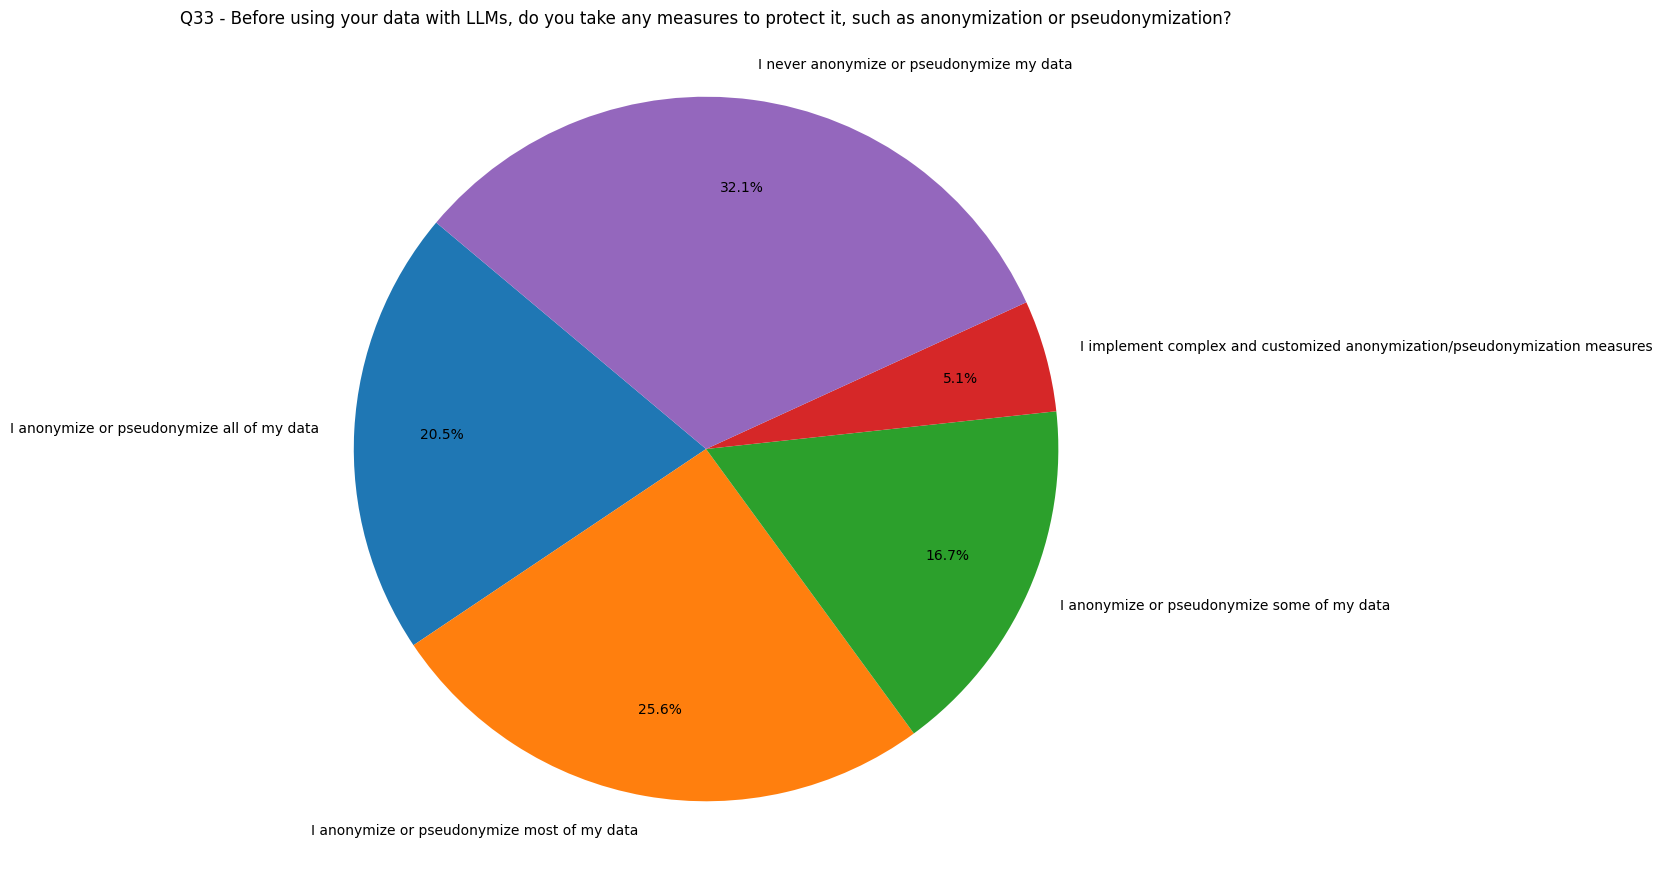

In [105]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))  # Initialize the figure and axes for the plot

# Pie chart
sizes = result_q33['qtde']  # The sizes of the pie chart sections based on the quantity
labels = result_q33['answer']  # The labels for each section of the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)  # Create the pie chart with percentage labels and starting angle
ax.set_title('Q33 - Before using your data with LLMs, do you take any measures to protect it, such as anonymization or pseudonymization?')  # Setting the title for the pie chart

ax.axis('equal')  # Ensures the pie chart is a perfect circle by maintaining equal aspect ratio

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)  # Adjust the spacing between the pie chart and the top of the figure

plt.show()  # Display the plot


In [106]:
def format_output(row):
  return f"{row['pct']:.1f}/{row['answer']},"

result_q33['formatted_output'] = result_q33.apply(format_output, axis=1)

for item in result_q33['formatted_output'].tolist():
  print(item)

20.5/I anonymize or pseudonymize all of my data,
25.6/I anonymize or pseudonymize most of my data,
16.7/I anonymize or pseudonymize some of my data,
5.1/I implement complex and customized anonymization/pseudonymization measures,
32.1/I never anonymize or pseudonymize my data,


In [107]:
result_q33 = result_q33.sort_values(by='pct', ascending=False)
result_q33 = result_q33.reset_index(drop=True)

In [108]:
print_dataframe_tuples_xbar(result_q33)

(32.1,I never anonymize or pseudonymize my data)
(25.6,I anonymize or pseudonymize most of my data)
(20.5,I anonymize or pseudonymize all of my data)
(16.7,I anonymize or pseudonymize some of my data)
(5.1,I implement complex and customized anonymization/pseudonymization measures)


In [109]:
result_q33['answer'].iloc[::-1].tolist()

['I implement complex and customized anonymization/pseudonymization measures',
 'I anonymize or pseudonymize some of my data',
 'I anonymize or pseudonymize all of my data',
 'I anonymize or pseudonymize most of my data',
 'I never anonymize or pseudonymize my data']

### Q34 - What are the main challenges you face when implementing privacy practices when using LLMs?
- Lack of clarity in privacy guidelines (laws and regulations)
- Challenges in compliance with privacy laws and regulations
- Ethical and legal uncertainties
- Challenges in data anonymization
- Difficulty in identifying and classifying sensitive data
- Limitations of LLM technology to handle sensitive data securely and ethically
- Lack of transparency of LLMs
- Lack of tools and resources in implementing privacy practices with LLMs
- Concerns about security and inappropriate access of sensitive data when using LLMs
- Lack of knowledge and expertise in privacy and LLMs
- Difficulty in measuring the impact of privacy practices
- Lack of awareness and training
- Lack of privacy culture in the organization
- Other

In [110]:
# Nome da coluna a ser processada
column_name = "Quais os principais desafios que você enfrenta ao implementar práticas de privacidade ao usar LLMs? (Marque todas as opções que se aplicam)"

# Processa a coluna de múltiplas opções (assumindo que a função process_multiple_option_column já foi definida)
result_q34 = process_multiple_option_column(df, column_name)

# Substituir o valor específico na coluna 'answer'
result_q34['answer'].replace({'não tenho dificuldade': 'Outros'}, inplace=True)
result_q34['answer'].replace({'O maior desafio é que a LGPD definiu tratamento como qualquer coisa que se faça com dados pessoais. Mas o entendimento geral foi que "mesmo sem utilizar o dado pessoal pra nada" receber ou olhar pra ele já é tratamento. Isso é um engano enorme e precisa ser corrigido. Se um cidadão jogar uma bola de papel com dados pessoais e falar que é Crente (dado sensível) dentro da minha empresa, ao abrir a bola de papel vou estar realizando tratamento de dados pessoais? Se olhar so pra "tratamento", sim, mas falta a finalidade. Qual a finalidade de tratar esses dados? nenhuma! Não ha finalidade. Eu abri a bola de papel pra ver o que tinha. tem dados pessoais, não etnho finalidade, jogo fora e vida que segue.... Se isso não for arrumado, vai dar uma confusão atras da outra, principalmente sobre treinamento de LLM.....': 'Outros'}, inplace=True)

result_q34.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
result_q34 = result_q34.groupby('answer', as_index=False).sum()


result_q34['pct'] = ((result_q34['qtde']/df.shape[0])*100).round(1)

# Aplicar a função de tradução a cada valor da coluna 'answer'
result_q34['answer'] = result_q34['answer'].apply(translate_to_english)

result_q34 = result_q34.sort_values(by='pct', ascending=False)
result_q34 = result_q34.reset_index(drop=True)

result_q34


,answer,qtde,pct
0,Ethical and legal uncertainties,43,55.1
1,Lack of clarity in privacy guidelines (laws and regulations),40,51.3
2,Challenges in data anonymization,31,39.7
3,Lack of transparency of LLMs,30,38.5
4,Challenges of Compliance with Privacy Laws and Regulations,29,37.2
5,Security concerns and improper access of sensitive data when using LLMs,25,32.1
6,Lack of awareness and training,24,30.8
7,Lack of knowledge and expertise in privacy and LLMs,22,28.2
8,Difficulty identifying and classifying sensitive data,19,24.4
9,Limitations of LLM technology for handling sensitive data securely and ethically,19,24.4


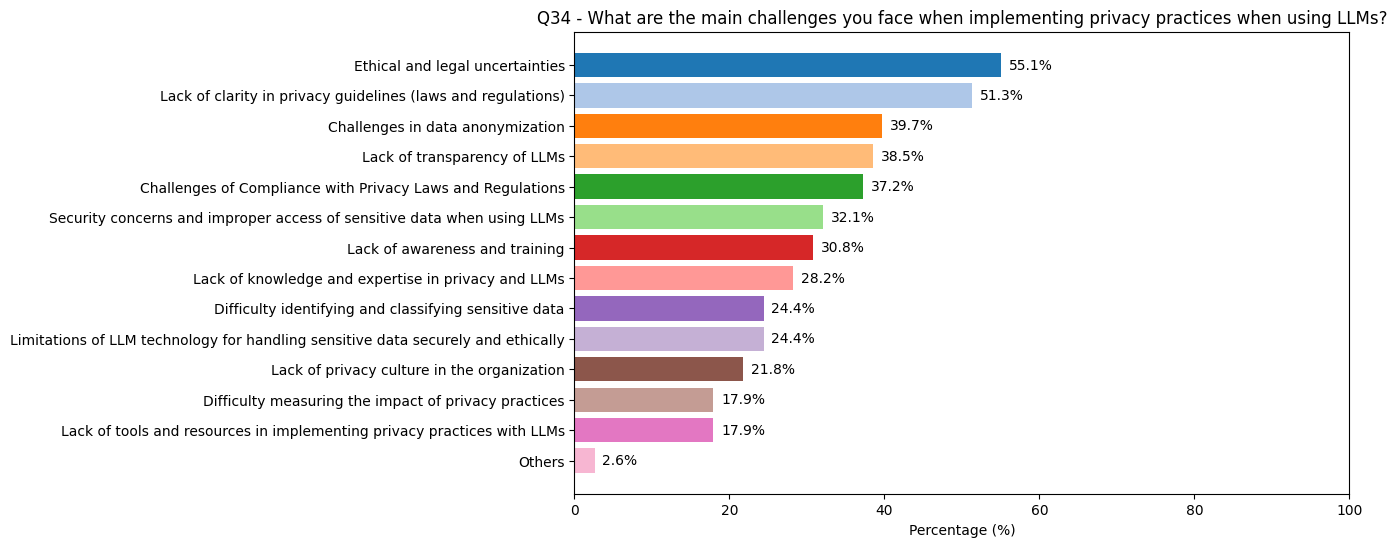

,Main challenges,Freq.,%
0,Ethical and legal uncertainties,43,55.1
1,Lack of clarity in privacy guidelines (laws and regulations),40,51.3
2,Challenges in data anonymization,31,39.7
3,Lack of transparency of LLMs,30,38.5
4,Challenges of Compliance with Privacy Laws and Regulations,29,37.2
5,Security concerns and improper access of sensitive data when using LLMs,25,32.1
6,Lack of awareness and training,24,30.8
7,Lack of knowledge and expertise in privacy and LLMs,22,28.2
8,Difficulty identifying and classifying sensitive data,19,24.4
9,Limitations of LLM technology for handling sensitive data securely and ethically,19,24.4


In [111]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q34)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q34['answer'], result_q34['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q34['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('Q34 - What are the main challenges you face when implementing privacy practices when using LLMs?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q34[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "Main challenges", "qtde": "Freq.", "pct": "%"}, inplace=True)
table_data

In [112]:
print_dataframe_tuples_xbar(result_q34)

(55.1,Ethical and legal uncertainties)
(51.3,Lack of clarity in privacy guidelines (laws and regulations))
(39.7,Challenges in data anonymization)
(38.5,Lack of transparency of LLMs)
(37.2,Challenges of Compliance with Privacy Laws and Regulations)
(32.1,Security concerns and improper access of sensitive data when using LLMs)
(30.8,Lack of awareness and training)
(28.2,Lack of knowledge and expertise in privacy and LLMs)
(24.4,Difficulty identifying and classifying sensitive data)
(24.4,Limitations of LLM technology for handling sensitive data securely and ethically)
(21.8,Lack of privacy culture in the organization)
(17.9,Difficulty measuring the impact of privacy practices)
(17.9,Lack of tools and resources in implementing privacy practices with LLMs)
(2.6,Others)


In [113]:
result_q34['answer'].iloc[::-1].tolist()

['Others',
 'Lack of tools and resources in implementing privacy practices with LLMs',
 'Difficulty measuring the impact of privacy practices',
 'Lack of privacy culture in the organization',
 'Limitations of LLM technology for handling sensitive data securely and ethically',
 'Difficulty identifying and classifying sensitive data',
 'Lack of knowledge and expertise in privacy and LLMs',
 'Lack of awareness and training',
 'Security concerns and improper access of sensitive data when using LLMs',
 'Challenges of Compliance with Privacy Laws and Regulations',
 'Lack of transparency of LLMs',
 'Challenges in data anonymization',
 'Lack of clarity in privacy guidelines (laws and regulations)',
 'Ethical and legal uncertainties']

## RQ5 - What are the challenges faced by Brazilian software developers in ensuring data privacy when using LLMs in their professional activities?


### Q35 - Which of the following challenges do you find most difficult when ensuring data privacy when using LLMs in your professional activities?
- Identify and classify sensitive data
- Adopt anonymization and pseudonymization measures
- Minimize data collection and retention
- Perform privacy impact assessments
- Achieve transparency on LLM use
- Comply with data privacy laws and regulations
- Ensure accountability for LLM use
- Other

In [114]:
column_name = "35. Quais dos seguintes desafios você considera mais difíceis ao garantir a privacidade de dados ao usar LLMs em suas atividades profissionais? (Marque todas as opções que se aplicam)"
result_q35 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Identificar e classificar dados sensíveis':'Identify and classify sensitive data',
    'Adotar medidas de anonimização e pseudonimização':'Adopt anonymization and pseudonymization measures',
    'Minimizar a coleta e retenção de dados':'Minimize data collection and retention',
    'Realizar avaliações de impacto de privacidade':'Perform privacy impact assessments',
    'Obter a transparência sobre o uso de LLM':'Achieve transparency on LLM use',
    'Cumprir as leis e regulamentações de privacidade de dados':'Comply with data privacy laws and regulations',
    'Garantir a responsabilização pelo uso de LLM':'Ensure accountability for LLM use',
    'Não sei':'Other',
    'sem dificuldade':'Other',
}
# Atualizando a coluna com os valores traduzidos
result_q35['answer'] = result_q35['answer'].map(translation_dict)

result_q35.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
result_q35 = result_q35.groupby('answer', as_index=False).sum()


result_q35['pct'] = ((result_q35['qtde']/df.shape[0])*100).round(1)

result_q35 = result_q35.sort_values(by='pct', ascending=False)
result_q35 = result_q35.reset_index(drop=True)


#result_q35

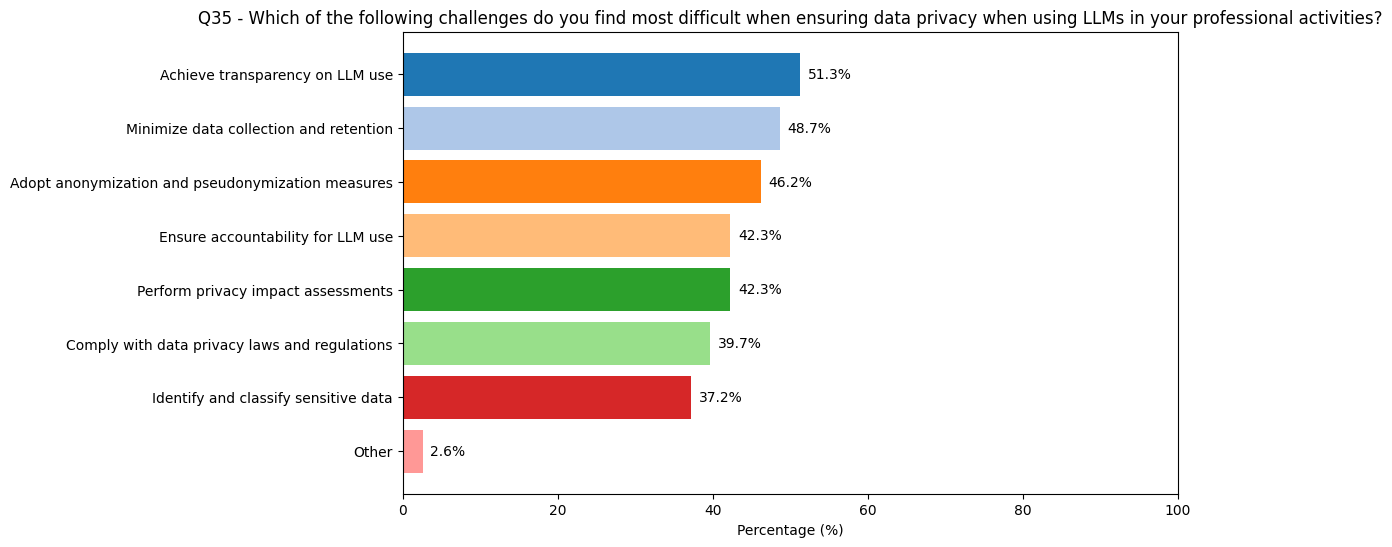

,Challenges,Freq.,%
0,Achieve transparency on LLM use,40,51.3
1,Minimize data collection and retention,38,48.7
2,Adopt anonymization and pseudonymization measures,36,46.2
3,Ensure accountability for LLM use,33,42.3
4,Perform privacy impact assessments,33,42.3
5,Comply with data privacy laws and regulations,31,39.7
6,Identify and classify sensitive data,29,37.2
7,Other,2,2.6


In [115]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q35)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q35['answer'], result_q35['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q35['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('Q35 - Which of the following challenges do you find most difficult when ensuring data privacy when using LLMs in your professional activities?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q35[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "Challenges", "qtde": "Freq.", "pct": "%"}, inplace=True)
table_data

In [116]:
print_dataframe_tuples_xbar(result_q35)

(51.3,Achieve transparency on LLM use)
(48.7,Minimize data collection and retention)
(46.2,Adopt anonymization and pseudonymization measures)
(42.3,Ensure accountability for LLM use)
(42.3,Perform privacy impact assessments)
(39.7,Comply with data privacy laws and regulations)
(37.2,Identify and classify sensitive data)
(2.6,Other)


In [117]:
result_q35['answer'].iloc[::-1].tolist()

['Other',
 'Identify and classify sensitive data',
 'Comply with data privacy laws and regulations',
 'Perform privacy impact assessments',
 'Ensure accountability for LLM use',
 'Adopt anonymization and pseudonymization measures',
 'Minimize data collection and retention',
 'Achieve transparency on LLM use']

### Q36 - Do you think current legislation is adequate to protect data privacy when using LLMs?
- Strongly Disagree (I believe that the current legislation is inadequate to protect data privacy when using LLMs and needs a complete overhaul)
- Somewhat Disagree (I believe that the current legislation is not sufficient to protect data privacy when using LLMs and needs to be strengthened)
- Neutral (I am not sure whether the current legislation is adequate to protect data privacy when using LLMs)
- Somewhat Agree (I believe that the current legislation provides a good level of protection for data privacy when using LLMs, but some improvements could be made)
- Strongly Agree (I believe that the current legislation provides comprehensive and effective protection for data privacy when using LLMs)

In [118]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q36_sts = df["36. Você acha que a legislação atual é adequada para proteger a privacidade de dados ao usar LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q36_sts = q36_sts.reset_index(drop=False)
q36_sts = q36_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' result_q40 to remove any text in parentheses and stripping spaces
q36_sts["question_anwser"] = q36_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Discordo totalmente': 1,
                'Discordo parcialmente': 2,
                'Neutro': 3,
                'Concordo parcialmente': 4,
                'Concordo totalmente': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q36_sts['ord_question_anwser'] = q36_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q36_sts = q36_sts.sort_values(by='ord_question_anwser', ascending=True)
q36_sts.drop('ord_question_anwser', axis=1, inplace=True)
q36_sts = q36_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q36_sts.rename(columns={'36. Você acha que a legislação atual é adequada para proteger a privacidade de dados ao usar LLMs? ': 'qtde'}, inplace=True)
q36_sts['pct'] = ((q36_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Discordo totalmente': 'Strongly Disagree',
                'Discordo parcialmente': 'Somewhat Disagree',
                'Neutro': 'Neutral',
                'Concordo parcialmente': 'Somewhat Agree',
                'Concordo totalmente': 'Strongly Agree'
                   }
# Atualizando a coluna com os valores traduzidos
q36_sts['question_anwser'] = q36_sts['question_anwser'].map(translation_dict)

q36_sts

,question_anwser,qtde,pct
0,Strongly Disagree,9,11.5
1,Somewhat Disagree,21,26.9
2,Neutral,32,41.0
3,Somewhat Agree,12,15.4
4,Strongly Agree,4,5.1


In [119]:
q36_sts['pct'].tolist()

[11.5, 26.9, 41.0, 15.4, 5.1]

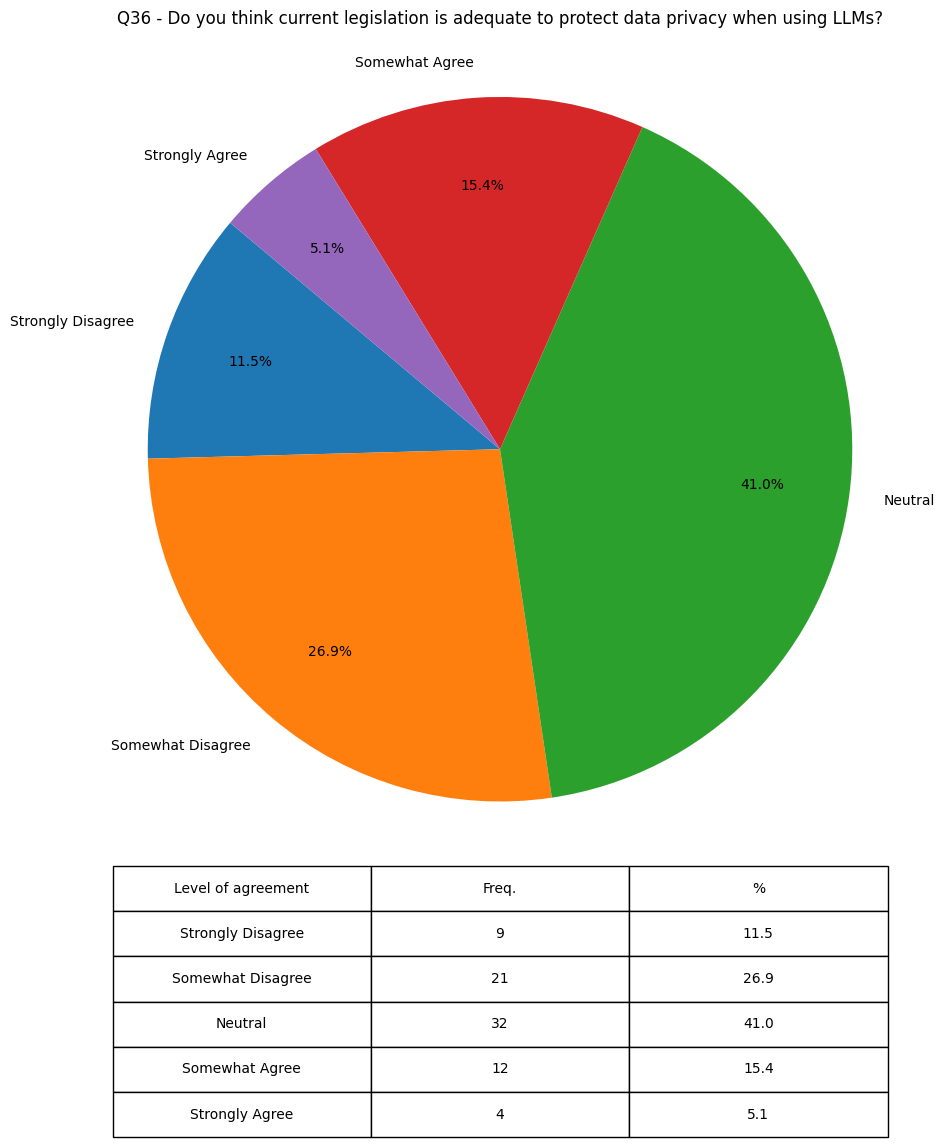

In [120]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q36_sts['qtde']
labels = q36_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('Q36 - Do you think current legislation is adequate to protect data privacy when using LLMs?')

# Adjusting the position and size of the table
table_data = q36_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "Level of agreement", "qtde": "Freq.", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q37 - Are you having trouble finding information or resources about data privacy when using LLMs?
- Strongly Disagree (I have no difficulty finding information and resources on how to ensure data privacy when using LLMs)
- Somewhat Disagree (I have a little difficulty finding information and resources on how to ensure data privacy when using LLMs)
- Neutral (I am not sure if I have difficulty finding information and resources on how to ensure data privacy when using LLMs)
- Somewhat Agree (I have some difficulty finding information and resources on how to ensure data privacy when using LLMs)
- Strongly Agree (I have a lot of difficulty finding information and resources on how to ensure data privacy when using LLMs)

In [121]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q37_sts = df["37. Você tem dificuldades em encontrar informações ou recursos sobre privacidade de dados ao usar LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q37_sts = q37_sts.reset_index(drop=False)
q37_sts = q37_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' result_q40 to remove any text in parentheses and stripping spaces
q37_sts["question_anwser"] = q37_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Discordo totalmente': 1,
                'Discordo parcialmente': 2,
                'Neutro': 3,
                'Concordo parcialmente': 4,
                'Concordo totalmente': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q37_sts['ord_question_anwser'] = q37_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q37_sts = q37_sts.sort_values(by='ord_question_anwser', ascending=True)
q37_sts.drop('ord_question_anwser', axis=1, inplace=True)
q37_sts = q37_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q37_sts.rename(columns={'37. Você tem dificuldades em encontrar informações ou recursos sobre privacidade de dados ao usar LLMs? ': 'qtde'}, inplace=True)
q37_sts['pct'] = ((q37_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Discordo totalmente': 'Strongly Disagree',
                'Discordo parcialmente': 'Somewhat Disagree',
                'Neutro': 'Neutral',
                'Concordo parcialmente': 'Somewhat Agree',
                'Concordo totalmente': 'Strongly Agree'
                   }
# Atualizando a coluna com os valores traduzidos
q37_sts['question_anwser'] = q37_sts['question_anwser'].map(translation_dict)

q37_sts

,question_anwser,qtde,pct
0,Strongly Disagree,2,2.6
1,Somewhat Disagree,5,6.4
2,Neutral,36,46.2
3,Somewhat Agree,25,32.1
4,Strongly Agree,10,12.8


In [122]:
q37_sts['pct'].tolist()

[2.6, 6.4, 46.2, 32.1, 12.8]

In [123]:
q37_sts['question_anwser'].tolist()

['Strongly Disagree',
 'Somewhat Disagree',
 'Neutral',
 'Somewhat Agree',
 'Strongly Agree']

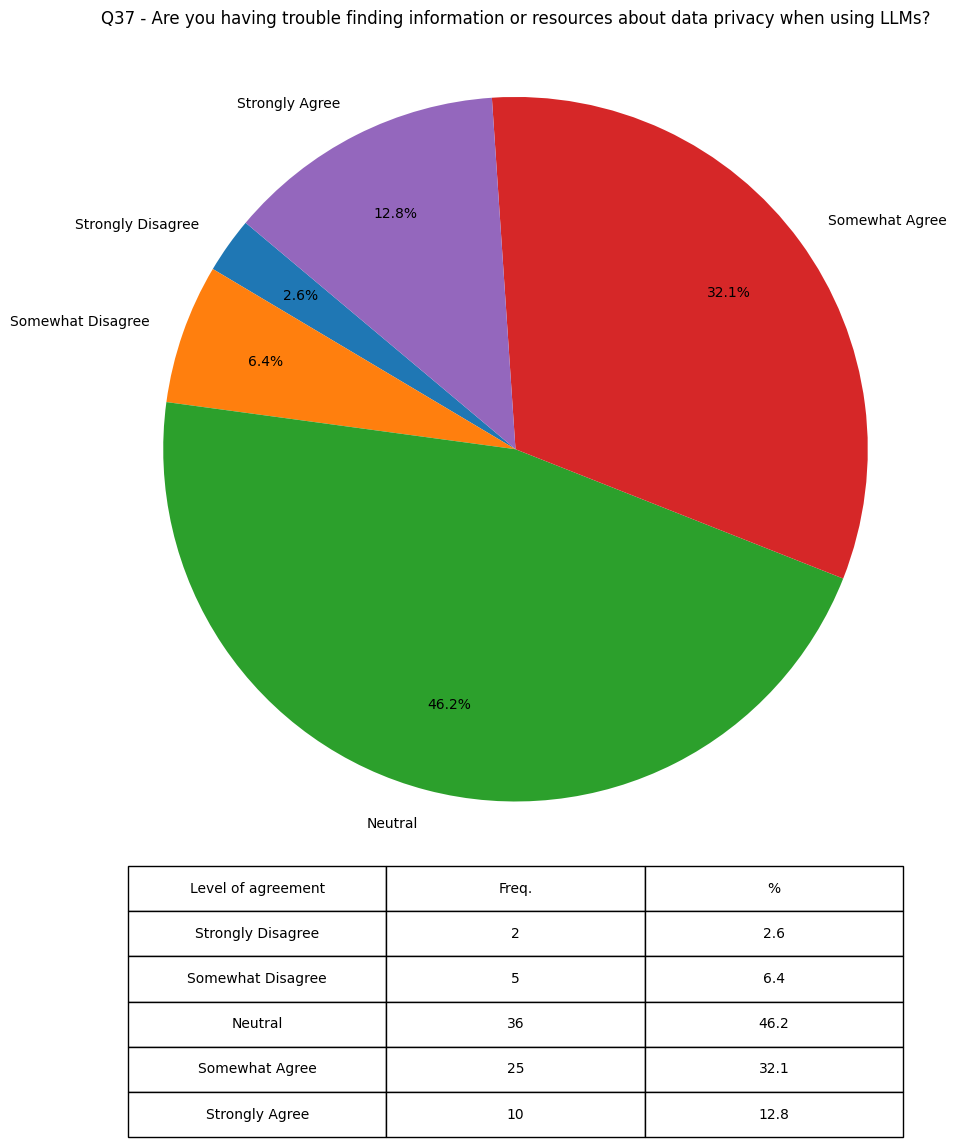

In [124]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q37_sts['qtde']
labels = q37_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('Q37 - Are you having trouble finding information or resources about data privacy when using LLMs?')

# Adjusting the position and size of the table
table_data = q37_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "Level of agreement", "qtde": "Freq.", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

### Q38 - How does the lack of specific knowledge about data privacy affect your work with LLMs?
- Difficulty identifying and classifying sensitive data.
- Uncertainty about best practices for data protection
- Difficulty using appropriate security measures
- Risk of not complying with data privacy laws and regulations
- Difficulty assessing privacy impacts
- Uncertainty about liability for use of LLMs
- Risk of data breaches
- Uncertainty about compliance with laws and regulations
- Limited ability to use LLMs safely and responsibly
- Other

In [125]:
column_name = "38. Como a falta de conhecimento específico sobre privacidade de dados afeta seu trabalho com LLMs? (Marque todas as opções que se aplicam)"
result_q38 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Dificuldade em identificar e classificar dados sensíveis.':'Difficulty identifying and classifying sensitive data.',
    'Incerteza sobre as melhores práticas de proteção de dados':'Uncertainty about best practices for data protection',
    'Dificuldade em usar medidas de segurança adequadas':'Difficulty using appropriate security measures',
    'Risco de não cumprir as leis e regulamentações de privacidade de dados':'Risk of not complying with data privacy laws and regulations',
    'Dificuldade na avaliação de impactos à privacidade':'Difficulty assessing privacy impacts',
    'Incerteza sobre a responsabilização pelo uso de LLM':'Uncertainty about liability for use of LLMs',
    'Risco de violações de dados':'Risk of data breaches',
    'Insegurança sobre a conformidade com leis e regulamentações':'Uncertainty about compliance with laws and regulations',
    'Limitação na capacidade de usar LLMs com segurança e responsabilidade':'Limited ability to use LLMs safely and responsibly',
    'Não afeta, pois tenho domínio do assunto':'Other',
    'Não uso LLMs no meu trabalho.':'Other',
    'sem dificuldade':'Other',
    'Sinto-me com conhecimento suficiente para uzar LLMs de forma segura.':'Other',
}
# Atualizando a coluna com os valores traduzidos
result_q38['answer'] = result_q38['answer'].map(translation_dict)

result_q38.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
result_q38 = result_q38.groupby('answer', as_index=False).sum()


result_q38['pct'] = ((result_q38['qtde']/df.shape[0])*100).round(1)

result_q38 = result_q38.sort_values(by='pct', ascending=False)
result_q38 = result_q38.reset_index(drop=True)


#result_q38

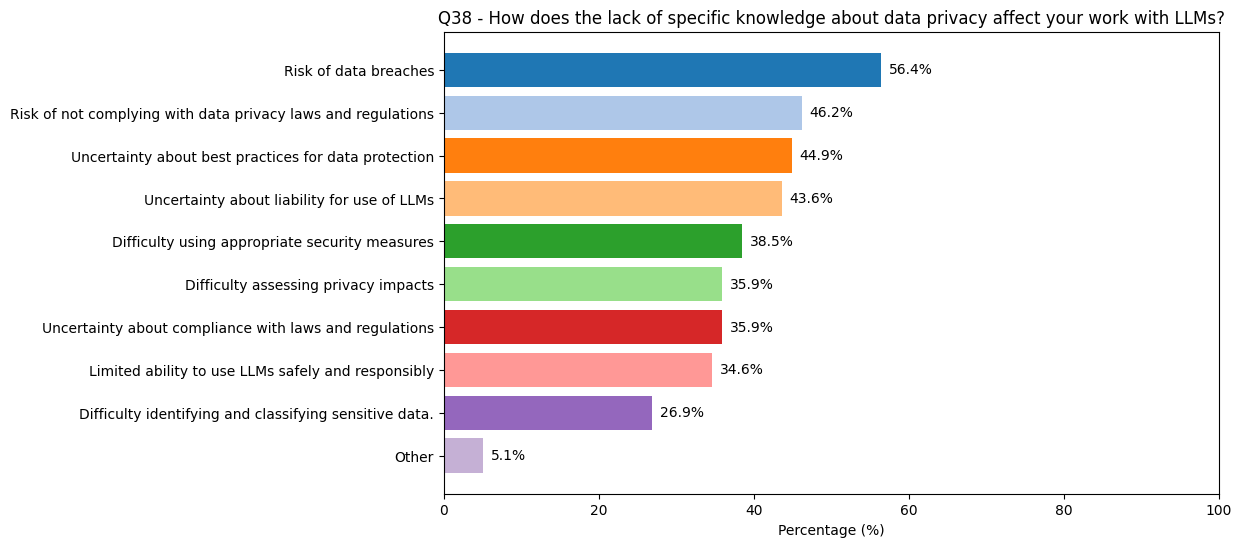

,Effect,Freq.,%
0,Risk of data breaches,44,56.4
1,Risk of not complying with data privacy laws and regulations,36,46.2
2,Uncertainty about best practices for data protection,35,44.9
3,Uncertainty about liability for use of LLMs,34,43.6
4,Difficulty using appropriate security measures,30,38.5
5,Difficulty assessing privacy impacts,28,35.9
6,Uncertainty about compliance with laws and regulations,28,35.9
7,Limited ability to use LLMs safely and responsibly,27,34.6
8,Difficulty identifying and classifying sensitive data.,21,26.9
9,Other,4,5.1


In [126]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q38)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q38['answer'], result_q38['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q38['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title('Q38 - How does the lack of specific knowledge about data privacy affect your work with LLMs?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q38[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "Effect", "qtde": "Freq.", "pct": "%"}, inplace=True)
table_data

In [127]:
print_dataframe_tuples_xbar(result_q38)

(56.4,Risk of data breaches)
(46.2,Risk of not complying with data privacy laws and regulations)
(44.9,Uncertainty about best practices for data protection)
(43.6,Uncertainty about liability for use of LLMs)
(38.5,Difficulty using appropriate security measures)
(35.9,Difficulty assessing privacy impacts)
(35.9,Uncertainty about compliance with laws and regulations)
(34.6,Limited ability to use LLMs safely and responsibly)
(26.9,Difficulty identifying and classifying sensitive data.)
(5.1,Other)


In [128]:
result_q38['answer'].iloc[::-1].tolist()

['Other',
 'Difficulty identifying and classifying sensitive data.',
 'Limited ability to use LLMs safely and responsibly',
 'Uncertainty about compliance with laws and regulations',
 'Difficulty assessing privacy impacts',
 'Difficulty using appropriate security measures',
 'Uncertainty about liability for use of LLMs',
 'Uncertainty about best practices for data protection',
 'Risk of not complying with data privacy laws and regulations',
 'Risk of data breaches']

## RQ6 - What are the recommendations for ensuring data privacy when using LLMs?

### Q39 - What recommendations would you give to other developers on how to protect data privacy when using LLMs?
Open Question

In [129]:
# Filtrar e renomear a coluna
df_filtered = df['39. Quais recomendações você daria para outros desenvolvedores sobre como proteger a privacidade de dados ao usar LLMs?'].to_frame()
df_filtered = df_filtered.dropna(subset=['39. Quais recomendações você daria para outros desenvolvedores sobre como proteger a privacidade de dados ao usar LLMs?'])
df_filtered = df_filtered.reset_index(drop=True)
df_filtered = df_filtered.rename(columns={'39. Quais recomendações você daria para outros desenvolvedores sobre como proteger a privacidade de dados ao usar LLMs?': 
                                          '39 - What recommendations would you give to other developers on how to protect data privacy when using LLMs?'})

# Aplicando a função de tradução a cada valor da coluna
df_filtered['39 - What recommendations would you give to other developers on how to protect data privacy when using LLMs?'] = df_filtered['39 - What recommendations would you give to other developers on how to protect data privacy when using LLMs?'].apply(translate_to_english)

# Imprimindo o DataFrame atualizado
df_filtered

,39 - What recommendations would you give to other developers on how to protect data privacy when using LLMs?
0,"They need to learn about privacy and personal data protection, AI governance and privacy enhance technologies."
1,"Create Firewall rules to block LLM attacks based on SQL injection, cross-site scripting and other attack vectors, which can generate false positive alerts."
2,"always use abstract examples within a hypothesis scenario, never concrete data in a real scenario"
3,Discover LLMs
4,Data anonymization
5,Use tools that run offline. Do not send personal data to external platforms.
6,"Tests in a segregated environment. Seek knowledge, participate in events. Be careful with manipulated data."
7,"Restricted, specific use and without sharing private data."
8,"Have an ethical, responsible attitude and stay up to date with laws and regulations."
9,Always anonymize private or sensitive data in prompts.


### Q40 - In your opinion, are more trainings and courses on data privacy and LLMs needed?
- Not necessary.
- Slightly necessary
- Neutral
- Necessary
- Very necessary

In [130]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q40_sts = df["40. Na sua opinião, mais treinamentos e cursos sobre privacidade de dados e LLMs são necessários?"].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q40_sts = q40_sts.reset_index(drop=False)
q40_sts = q40_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' result_q40 to remove any text in parentheses and stripping spaces
q40_sts["question_anwser"] = q40_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Não é necessário.': 1,
                'Pouco necessário': 2,
                'Neutro': 3,
                'Necessário': 4,
                'Muito necessário': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q40_sts['ord_question_anwser'] = q40_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q40_sts = q40_sts.sort_values(by='ord_question_anwser', ascending=True)
q40_sts.drop('ord_question_anwser', axis=1, inplace=True)
q40_sts = q40_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q40_sts.rename(columns={'40. Na sua opinião, mais treinamentos e cursos sobre privacidade de dados e LLMs são necessários?': 'qtde'}, inplace=True)
q40_sts['pct'] = ((q40_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Não é necessário.': 'Not necessary',
                'Pouco necessário': 'Slightly necessary',
                'Neutro': 'Neutral',
                'Necessário': 'Necessary',
                'Muito necessário': 'Very necessary'
                   }
# Atualizando a coluna com os valores traduzidos
q40_sts['question_anwser'] = q40_sts['question_anwser'].map(translation_dict)

q40_sts

,question_anwser,qtde,pct
0,Not necessary,1,1.3
1,Neutral,4,5.1
2,Necessary,36,46.2
3,Very necessary,37,47.4


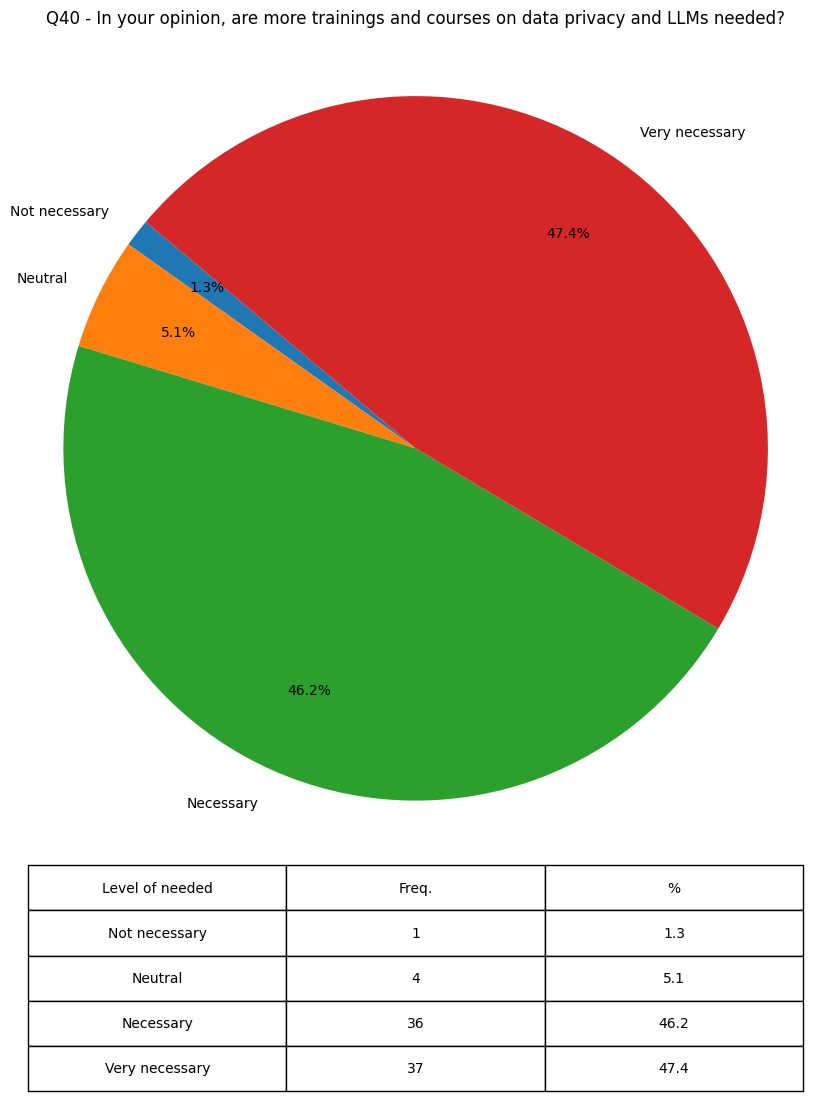

In [131]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q40_sts['qtde']
labels = q40_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('Q40 - In your opinion, are more trainings and courses on data privacy and LLMs needed?')

# Adjusting the position and size of the table
table_data = q40_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "Level of needed", "qtde": "Freq.", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

In [132]:

q40_sts['formatted_output'] = q40_sts.apply(format_output, axis=1)

for item in q40_sts['formatted_output'].tolist():
  print(item)

1.3/Not necessary,
5.1/Neutral,
46.2/Necessary,
47.4/Very necessary,


### Q41 - In your opinion, how important is it to have an organizational culture that addresses data privacy when using LLMs?
- Not important
- Slightly important
- Neutral
- Important:
- Very important

In [133]:
# Counting the occurrences of each education level in the specified column and converting to a DataFrame
q41_sts = df["41.  Na sua opinião, quão importante é ter uma cultura organizacional que aborda a privacidade de dados ao usar LLMs? "].value_counts().to_frame()

# Resetting the index to convert the index to a column and renaming columns
q41_sts = q41_sts.reset_index(drop=False)
q41_sts = q41_sts.rename(columns={'index': 'question_anwser'})

# Splitting the 'question_anwser' result_q40 to remove any text in parentheses and stripping spaces
q41_sts["question_anwser"] = q41_sts["question_anwser"].str.split('(', expand=True)[0].str.strip()


# Creating a dictionary to map education levels to numerical values
mapping_dict = {'Não é importante': 1,
                'Pouco importante': 2,
                'Neutro': 3,
                'Importante:.': 4,
                'Muito importante': 5}

# Creating a new column 'ord_escolaridade' based on the mapping dictionary for sorting purposes
q41_sts['ord_question_anwser'] = q41_sts['question_anwser'].map(mapping_dict)


# Sorting the DataFrame by 'ord_escolaridade' in ascending order and dropping the column
q41_sts = q41_sts.sort_values(by='ord_question_anwser', ascending=True)
q41_sts.drop('ord_question_anwser', axis=1, inplace=True)
q41_sts = q41_sts.reset_index(drop=True)


# Renaming the column '3. Qual seu nível de escolaridade?' to 'qtde' and calculating the percentage
q41_sts.rename(columns={'41.  Na sua opinião, quão importante é ter uma cultura organizacional que aborda a privacidade de dados ao usar LLMs? ': 'qtde'}, inplace=True)
q41_sts['pct'] = ((q41_sts['qtde']/df.shape[0])*100).round(1)

# Dicionário de tradução
translation_dict = {'Não é importante': 'Not important',
                'Pouco importante': 'Slightly important',
                'Neutro': 'Neutral',
                'Importante:.': 'Important',
                'Muito importante': 'Very important'
                   }
# Atualizando a coluna com os valores traduzidos
q41_sts['question_anwser'] = q41_sts['question_anwser'].map(translation_dict)

q41_sts

,question_anwser,qtde,pct
0,Not important,1,1.3
1,Neutral,4,5.1
2,Important,27,34.6
3,Very important,46,59.0


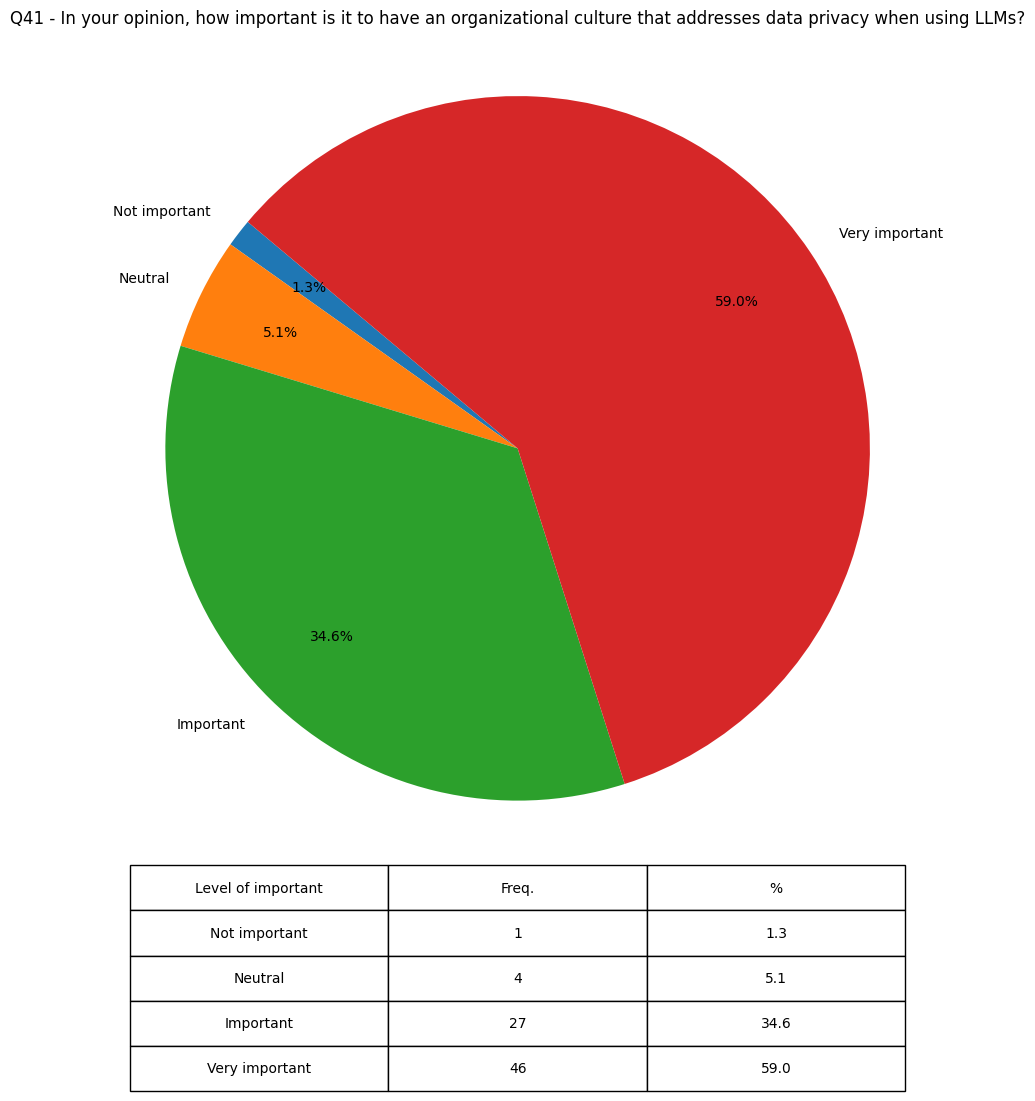

In [134]:
# Creating the pie chart and centered table below
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
sizes = q41_sts['qtde']
labels = q41_sts['question_anwser']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, pctdistance=0.75)
ax.set_title('Q41 - In your opinion, how important is it to have an organizational culture that addresses data privacy when using LLMs?')

# Adjusting the position and size of the table
table_data = q41_sts[['question_anwser', 'qtde', 'pct']]
table_data.rename(columns={"question_anwser": "Level of important", "qtde": "Freq.", "pct": "%"}, inplace=True)
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Scaling the table size
ax.axis('equal')  # Maintains the aspect ratio of the pie chart

# Adjusting the spacing between the pie chart and the table
fig.subplots_adjust(top=1.5)

plt.show()

In [135]:

q41_sts['formatted_output'] = q41_sts.apply(format_output, axis=1)

for item in q41_sts['formatted_output'].tolist():
  print(item)

1.3/Not important,
5.1/Neutral,
34.6/Important,
59.0/Very important,


### Q42 - What kind of support or additional resources do you think would be helpful to improve data privacy protection when using LLMs?
- Clear guidelines and best practices
- Privacy tools and technologies
- Privacy training and capacity building
- Public awareness and education campaigns
- Legal and regulatory guidance
- Privacy assessment solutions
- Privacy research and development for LLMs
- Collaboration and knowledge sharing forums
- Other

In [136]:
column_name = "42. Que tipo de suporte ou recursos adicionais você acredita que seriam úteis para melhorar a proteção da privacidade de dados ao usar LLMs? (Marque todas as opções que se aplicam)"
result_q42 = process_multiple_option_column(df, column_name)

# Dicionário de tradução
translation_dict = {
    'Diretrizes e melhores práticas claras':'Clear guidelines and best practices',
    'Ferramentas e tecnologias de privacidade':'Privacy tools and technologies',
    'Treinamentos e capacitação em privacidade':'Privacy training and capacity building',
    'Campanhas de educação e conscientização pública':'Public awareness and education campaigns',
    'Orientação jurídica e regulatória':'Legal and regulatory guidance',
    'Soluções de avaliação de privacidade':'Privacy assessment solutions',
    'Pesquisa e desenvolvimento em privacidade para LLMs':'Privacy research and development for LLMs',
    'Fóruns de colaboração e compartilhamento de conhecimento':'Collaboration and knowledge sharing forums',
    'a possibilidade de IAs de navegação anônima amnésica':'Other',
    'nenhum':'Other'
}

result_q42['answer'] = result_q42['answer'].str.strip()

# Atualizando a coluna com os valores traduzidos
result_q42['answer'] = result_q42['answer'].map(translation_dict)

result_q42.drop('pct', axis=1, inplace=True)

# Agrupar por 'answer' e somar as quantidades
result_q42 = result_q42.groupby('answer', as_index=False).sum()


result_q42['pct'] = ((result_q42['qtde']/df.shape[0])*100).round(1)

result_q42 = result_q42.sort_values(by='pct', ascending=False)
result_q42 = result_q42.reset_index(drop=True)


#result_q42

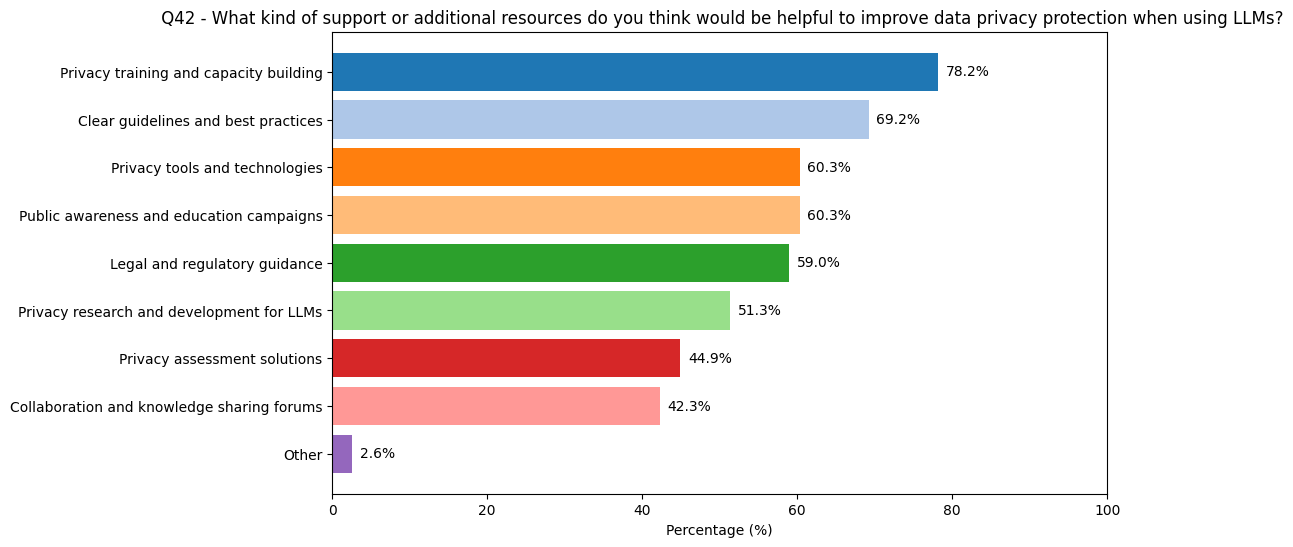

,Support or additional resources,Freq.,%
0,Privacy training and capacity building,61,78.2
1,Clear guidelines and best practices,54,69.2
2,Privacy tools and technologies,47,60.3
3,Public awareness and education campaigns,47,60.3
4,Legal and regulatory guidance,46,59.0
5,Privacy research and development for LLMs,40,51.3
6,Privacy assessment solutions,35,44.9
7,Collaboration and knowledge sharing forums,33,42.3
8,Other,2,2.6


In [137]:
# Defining a color palette with different colors for each bar
colors = plt.cm.tab20(range(len(result_q42)))

# Plotting horizontal bar chart with percentage values and different colors
plt.figure(figsize=(10, 6))
bars = plt.barh(result_q42['answer'], result_q42['pct'], color=colors)

# Adding percentage values on the bars
for bar, pct in zip(bars, result_q42['pct']):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct}%', ha='left', va='center', fontsize=10)

plt.xlabel('Percentage (%)')
plt.title(' Q42 - What kind of support or additional resources do you think would be helpful to improve data privacy protection when using LLMs?')
plt.xlim(0, 100)  # Setting the x-axis limit from 0 to 100
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

## Displaying table with qtde and pct values
table_data = result_q42[['answer', 'qtde', 'pct']]
table_data.rename(columns={"answer": "Support or additional resources", "qtde": "Freq.", "pct": "%"}, inplace=True)
table_data

In [138]:
print_dataframe_tuples_xbar(result_q42)

(78.2,Privacy training and capacity building)
(69.2,Clear guidelines and best practices)
(60.3,Privacy tools and technologies)
(60.3,Public awareness and education campaigns)
(59.0,Legal and regulatory guidance)
(51.3,Privacy research and development for LLMs)
(44.9,Privacy assessment solutions)
(42.3,Collaboration and knowledge sharing forums)
(2.6,Other)


In [139]:
result_q42['answer'].iloc[::-1].tolist()

['Other',
 'Collaboration and knowledge sharing forums',
 'Privacy assessment solutions',
 'Privacy research and development for LLMs',
 'Legal and regulatory guidance',
 'Public awareness and education campaigns',
 'Privacy tools and technologies',
 'Clear guidelines and best practices',
 'Privacy training and capacity building']

# Dataframe Translation
Translation of dataframe from Portuguese to English

In [ ]:
# Googletrans is a free and unlimited python library that implements the Google Translate API.
# Documentation: https://py-googletrans.readthedocs.io/en/latest/

# To install the specific version of googletrans:
# !pip install -q -U googletrans==3.1.0a0 

from googletrans import Translator

# Use Example

# Create a Translator object
# translator = Translator()

# Translate a text from Portuguese to English
# translation = translator.translate('1. Qual a sua idade?', src='pt', dest='en')
# Print the translated text
# translation.text

In [ ]:
from googletrans import Translator

def translate_to_english(sentence):
    """
    Translates a given sentence from Portuguese to English.

    Parameters:
    sentence (str): The sentence in Portuguese to be translated.

    Returns:
    str: The translated sentence in English.
    """
    # Create a Translator object
    # translator = Translator()
    translator = Translator(timeout=httpx.Timeout(40.0))
    
    # Translate the text from Portuguese to English
    translation = translator.translate(sentence, src='pt', dest='en')
    
    # Return the translated text
    return translation.text

In [262]:
# Function to translate text
def translate_text(text, translator):
    # Check if the text is NaN (Not a Number)
    if pd.isna(text):
        return text
    try:
        # Try to translate the text from Portuguese to English
        translated = translator.translate(text, src='pt', dest='en')
        return translated.text
    except Exception as e:
        # Print an error message if translation fails
        print(f"Error translating text '{text}': {e}")
        return text

# Define the translation function
def translate_to_english(text):
    # Create a Translator object
    translator = Translator()
    # Translate the text from Portuguese to English
    translation = translator.translate(text, src='pt', dest='en')
    return translation.text

# Function to translate the column names of a DataFrame
def translate_column_names(df):
    # Create a dictionary to map the translated column names
    translated_columns = {col: translate_to_english(col) for col in df.columns}
    
    # Rename the columns of the DataFrame using the translated names
    df_translated = df.rename(columns=translated_columns)
    
    return df_translated

In [264]:
# Read the DataFrame
df = pd.read_csv('QUESTIONÁRIO ONLINE: Investigando a Percepção dos Desenvolvedores Brasileiros de Software  sobre Privacidade de Dados no uso de  LLMs.csv')

# Create a Translator object
translator = Translator()

# Translate the content of the DataFrame
df_translated = df.applymap(lambda x: translate_text(x, translator))

# Save the translated DataFrame to a CSV file
#df_translated.to_csv('translated_dataframe.csv', index=False)

In [265]:
# Create a copy of the DataFrame
df = df_translated.copy()

# Call the function to translate the column names
df_translated_v2 = translate_column_names(df)

# Save the translated DataFrame to a CSV file
df_translated_v2.to_csv('All_Respondents_Answers.csv', index=False)

# Display the DataFrame with the translated column names
# print(df_translated_v2)

                       Timestamp  \
0   2024/05/27 11:22:05 AM GMT-3   
1    2024/05/27 7:07:52 PM GMT-3   
2    2024/05/27 7:59:24 PM GMT-3   
3    2024/05/27 8:00:27 PM GMT-3   
4    2024/05/29 8:39:57 AM GMT-3   
..                           ...   
73   2024/06/30 7:57:22 PM GMT-3   
74   2024/07/08 3:19:46 PM GMT-3   
75   2024/07/10 4:53:39 PM GMT-3   
76   2024/07/10 7:39:41 PM GMT-3   
77   2024/07/11 6:44:06 AM GMT-3   

   Do you agree to participate in this research?          1. How old are you?  \
0                                            Yes  Between 43 and 47 years old   
1                                            Yes  Between 55 and 60 years old   
2                                            Yes  Between 37 and 42 years old   
3                                            Yes  Between 31 and 36 years old   
4                                            Yes  Between 43 and 47 years old   
..                                           ...                          ...   


In [ ]:
from googletrans import Translator
import pandas as pd

# Defining the translation function
def translate_to_english(text):
    translator = Translator()
    translation = translator.translate(text, src='pt', dest='en')
    return translation.text

# Function to translate a specific column of the DataFrame
def translate_column(df, column_name):
    # Checks if the column exists in the DataFrame
    if column_name not in df.columns:
        raise KeyError(f"Column '{column_name}' not found in DataFrame.")
    
    # Creates a copy of the DataFrame to avoid modifying the original
    df_translated = df.copy()
    
    # Applies the translation function to each value of the column
    df_translated[column_name] = df_translated[column_name].apply(translate_to_english)
    
    return df_translated

# Calls the function to translate the desired column
column_to_translate = '30. Quais medidas você toma para mitigar os riscos de privacidade ao usar LLMs? '
df_translated = translate_column(df, column_to_translate)

# Displays the translated DataFrame
#print(df_translated)

df_translated['30. Quais medidas você toma para mitigar os riscos de privacidade ao usar LLMs? ']
